# 1. Import libraries and data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed, save, load
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
import warnings
warnings.filterwarnings("ignore")
set_random_seed(99)

C:\Users\namtrantuan\AppData\Roaming\Python\Python39\site-packages\plotly_resampler\aggregation\aggregators.py:25: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


In [2]:
pd.options.display.float_format = '{:20,.0f}'.format

In [3]:
dom = pd.read_excel('dom.xlsx')
dom = dom.rename(columns={'DATE': 'ds', 'Pax': 'y'})

In [4]:
dom.head()

,ds,y,seat
0,2015-01-01,"52,356",59972
1,2015-01-02,"47,811",56277
2,2015-01-03,"49,555",60035
3,2015-01-04,"57,680",62548
4,2015-01-05,"50,193",58566


In [5]:
dom.drop('seat', axis = 1, inplace = True)

<AxesSubplot:xlabel='ds'>

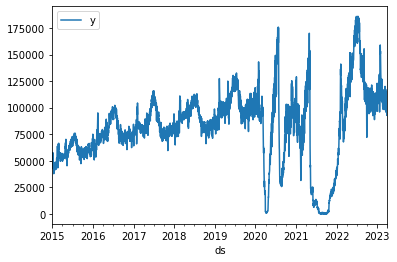

In [6]:
dom.set_index('ds').plot()

In [7]:
holidays = pd.read_excel('covid.xlsx')

In [8]:
# changepoints là những mốc bắt đầu và kết thúc của các đợt dịch covid hoặc thay đổi về trend:
# changepoints = ['2020-03-09','2020-05-31','2020-07-28','2020-09-30','2021-01-25','2021-03-31','2021-04-30','2021-10-22']

# 2. Build models

## 2.1. Neural prophet

In [9]:
train = dom[dom['ds'] < '2022-07-01'].copy()
val = dom[(dom['ds'] >= '2022-07-01')&(dom['ds'] < '2023-01-01')].copy()
test = dom[dom['ds'] >= '2023-01-01'].copy()

In [10]:
holidays = holidays.rename(columns={'holiday': 'event'})
train_holidays = holidays[holidays['ds'] < '2022-07-01'].copy()
val_holidays = holidays[(holidays['ds'] >= '2022-07-01')&(holidays['ds'] < '2023-01-01')].copy()
test_holidays = holidays[holidays['ds'] >= '2023-01-01'].copy()

In [11]:
def objective(trial):
    set_random_seed(99)
    """Define the objective function"""

    params = {
        'trend_reg': trial.suggest_float('trend_reg',0.001,100),
        'n_changepoints':trial.suggest_int('n_changepoints',10,40),
        'changepoints_range': trial.suggest_float('changepoints_range',0.7,0.95),
        'seasonality_reg': trial.suggest_float('seasonality_reg',0.1, 100),
        'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative', 'additive']),
        'yearly_seasonality':trial.suggest_int('yearly_seasonality',10,40),
        'weekly_seasonality':trial.suggest_int('weekly_seasonality',1,40),
        'learning_rate':trial.suggest_float('learning_rate',0.001,10),
        'loss_func':trial.suggest_categorical('loss_func',['Huber', 'MAE'])
    }
    events_params_1 = {'regularization':trial.suggest_float('event1_regularization',0,0.2),
                      'mode':trial.suggest_categorical('event1_mode',['multiplicative', 'additive'])}
    
    # Create the model
    optuna_model = NeuralProphet(**params, daily_seasonality = False)
    optuna_model.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'], **events_params_1)  

    # create the data df with events
    df = optuna_model.create_df_with_events(dom,holidays)
    
    # Fit the model
    metrics = optuna_model.fit(df, freq="D")

    # Make predictions
    optuna_forecast = optuna_model.predict(df=df)

    # Evaluate prediction
    rmse = np.sqrt(mean_squared_error(dom.set_index('ds')['y'], optuna_forecast.set_index('ds')['yhat1'])).round(2)
    return rmse

In [12]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=99))

[I 2023-04-25 09:49:36,394] A new study created in memory with name: no-name-26855a62-8d14-48b1-b409-3251c0dd9e8f


In [13]:
study.optimize(objective, n_trials=300)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 141


Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:50:38,959] Trial 0 finished with value: 34245.55 and parameters: {'trend_reg': 67.22818358452055, 'n_changepoints': 25, 'changepoints_range': 0.9063737935089741, 'seasonality_reg': 3.241494123867185, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 2, 'learning_rate': 9.906283367308491, 'loss_func': 'MAE', 'event1_regularization': 0.14935342019885994, 'event1_mode': 'additive'}. Best is trial 0 with value: 34245.55.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major fr

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:51:40,480] Trial 1 finished with value: 21499.99 and parameters: {'trend_reg': 92.89491026116583, 'n_changepoints': 22, 'changepoints_range': 0.9434890742072399, 'seasonality_reg': 52.48903006598649, 'seasonality_mode': 'additive', 'yearly_seasonality': 16, 'weekly_seasonality': 23, 'learning_rate': 2.923398890475657, 'loss_func': 'MAE', 'event1_regularization': 0.04431547434591554, 'event1_mode': 'multiplicative'}. Best is trial 1 with value: 21499.99.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:52:41,002] Trial 2 finished with value: 31546.53 and parameters: {'trend_reg': 41.16691222105499, 'n_changepoints': 13, 'changepoints_range': 0.7360027497269211, 'seasonality_reg': 21.298397914024147, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 1, 'learning_rate': 8.986543226536925, 'loss_func': 'Huber', 'event1_regularization': 0.1857756366991472, 'event1_mode': 'multiplicative'}. Best is trial 1 with value: 21499.99.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:53:42,442] Trial 3 finished with value: 31543.5 and parameters: {'trend_reg': 52.48815911936133, 'n_changepoints': 29, 'changepoints_range': 0.9001645409116026, 'seasonality_reg': 83.50839328389196, 'seasonality_mode': 'additive', 'yearly_seasonality': 24, 'weekly_seasonality': 11, 'learning_rate': 5.4942347997429035, 'loss_func': 'Huber', 'event1_regularization': 0.183092499795969, 'event1_mode': 'multiplicative'}. Best is trial 1 with value: 21499.99.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:54:43,390] Trial 4 finished with value: 20823.04 and parameters: {'trend_reg': 43.27950072977551, 'n_changepoints': 32, 'changepoints_range': 0.9128359976679463, 'seasonality_reg': 7.996763862602297, 'seasonality_mode': 'additive', 'yearly_seasonality': 40, 'weekly_seasonality': 29, 'learning_rate': 6.366564407011875, 'loss_func': 'MAE', 'event1_regularization': 0.032002014806300626, 'event1_mode': 'additive'}. Best is trial 4 with value: 20823.04.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:55:44,580] Trial 5 finished with value: 35119.8 and parameters: {'trend_reg': 95.79804191390964, 'n_changepoints': 10, 'changepoints_range': 0.7781486144373989, 'seasonality_reg': 4.986377428906286, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 37, 'learning_rate': 1.532031429523175, 'loss_func': 'MAE', 'event1_regularization': 0.10325058166133659, 'event1_mode': 'additive'}. Best is trial 4 with value: 20823.04.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major fr

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:56:47,570] Trial 6 finished with value: 14125.68 and parameters: {'trend_reg': 23.52741867624783, 'n_changepoints': 13, 'changepoints_range': 0.8534700104572721, 'seasonality_reg': 24.441264772613643, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 15, 'learning_rate': 1.0355598391613605, 'loss_func': 'Huber', 'event1_regularization': 0.046564828923349594, 'event1_mode': 'multiplicative'}. Best is trial 6 with value: 14125.68.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:57:51,325] Trial 7 finished with value: 34329.76 and parameters: {'trend_reg': 74.46498055232672, 'n_changepoints': 30, 'changepoints_range': 0.8925094076358701, 'seasonality_reg': 79.05414246555915, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 40, 'weekly_seasonality': 5, 'learning_rate': 4.149997900329959, 'loss_func': 'MAE', 'event1_regularization': 0.16137532276780645, 'event1_mode': 'multiplicative'}. Best is trial 6 with value: 14125.68.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Ma

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:58:52,931] Trial 8 finished with value: 31642.0 and parameters: {'trend_reg': 33.17101666858025, 'n_changepoints': 12, 'changepoints_range': 0.8810563587373272, 'seasonality_reg': 75.16023577407414, 'seasonality_mode': 'additive', 'yearly_seasonality': 14, 'weekly_seasonality': 9, 'learning_rate': 8.482478622642944, 'loss_func': 'Huber', 'event1_regularization': 0.1545161040649919, 'event1_mode': 'multiplicative'}. Best is trial 6 with value: 14125.68.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major fr

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 09:59:54,553] Trial 9 finished with value: 14974.97 and parameters: {'trend_reg': 68.9534708091899, 'n_changepoints': 17, 'changepoints_range': 0.8758412131939324, 'seasonality_reg': 40.00609474544781, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 29, 'learning_rate': 0.7698121462569356, 'loss_func': 'MAE', 'event1_regularization': 0.1932141073793692, 'event1_mode': 'multiplicative'}. Best is trial 6 with value: 14125.68.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Ma

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:00:55,694] Trial 10 finished with value: 34930.51 and parameters: {'trend_reg': 0.7124712262024246, 'n_changepoints': 38, 'changepoints_range': 0.8257845645458166, 'seasonality_reg': 39.39876977364909, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 18, 'learning_rate': 0.34793658931291116, 'loss_func': 'Huber', 'event1_regularization': 0.07295486910675925, 'event1_mode': 'multiplicative'}. Best is trial 6 with value: 14125.68.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:01:57,468] Trial 11 finished with value: 28784.83 and parameters: {'trend_reg': 17.178331726675097, 'n_changepoints': 18, 'changepoints_range': 0.8471889702207538, 'seasonality_reg': 39.61585269617671, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 31, 'learning_rate': 0.006428650061600871, 'loss_func': 'Huber', 'event1_regularization': 0.09569588596147625, 'event1_mode': 'multiplicative'}. Best is trial 6 with value: 14125.68.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:02:59,130] Trial 12 finished with value: 13289.38 and parameters: {'trend_reg': 22.171791907317687, 'n_changepoints': 17, 'changepoints_range': 0.7918290781164165, 'seasonality_reg': 58.5617468298263, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 19, 'learning_rate': 2.406011628729108, 'loss_func': 'Huber', 'event1_regularization': 0.005691080198465419, 'event1_mode': 'multiplicative'}. Best is trial 12 with value: 13289.38.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:04:00,053] Trial 13 finished with value: 13172.24 and parameters: {'trend_reg': 20.485887604045722, 'n_changepoints': 17, 'changepoints_range': 0.7873858118945568, 'seasonality_reg': 53.04604163365102, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 17, 'learning_rate': 2.492697903445471, 'loss_func': 'Huber', 'event1_regularization': 0.002361931148321143, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:05:00,828] Trial 14 finished with value: 35608.13 and parameters: {'trend_reg': 1.4458947005705838, 'n_changepoints': 19, 'changepoints_range': 0.7764645882662827, 'seasonality_reg': 64.67494592869227, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 22, 'learning_rate': 2.6806574609036455, 'loss_func': 'Huber', 'event1_regularization': 0.006102905299852782, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:06:01,958] Trial 15 finished with value: 13759.77 and parameters: {'trend_reg': 13.528855476046097, 'n_changepoints': 22, 'changepoints_range': 0.7822931806830582, 'seasonality_reg': 59.65973150337797, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 15, 'learning_rate': 3.3591319016434116, 'loss_func': 'Huber', 'event1_regularization': 0.0021550091754716926, 'event1_mode': 'additive'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:07:03,755] Trial 16 finished with value: 13262.25 and parameters: {'trend_reg': 21.94592466117344, 'n_changepoints': 16, 'changepoints_range': 0.704943531635617, 'seasonality_reg': 98.60586615442965, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 23, 'learning_rate': 2.0385246925424108, 'loss_func': 'Huber', 'event1_regularization': 0.021666845002173394, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:08:05,551] Trial 17 finished with value: 14096.41 and parameters: {'trend_reg': 31.65187186406649, 'n_changepoints': 22, 'changepoints_range': 0.7000596025169017, 'seasonality_reg': 88.88280132581882, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 25, 'learning_rate': 4.892948122962183, 'loss_func': 'Huber', 'event1_regularization': 0.02789550236056952, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:09:07,401] Trial 18 finished with value: 31505.02 and parameters: {'trend_reg': 50.74346748403427, 'n_changepoints': 15, 'changepoints_range': 0.7018562065155399, 'seasonality_reg': 96.56847144392698, 'seasonality_mode': 'additive', 'yearly_seasonality': 36, 'weekly_seasonality': 36, 'learning_rate': 1.8690557587600858, 'loss_func': 'Huber', 'event1_regularization': 0.07747938639068251, 'event1_mode': 'additive'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major fr

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:10:09,653] Trial 19 finished with value: 16650.24 and parameters: {'trend_reg': 14.472119217919746, 'n_changepoints': 25, 'changepoints_range': 0.7401893052759229, 'seasonality_reg': 71.01467190786518, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 37, 'weekly_seasonality': 12, 'learning_rate': 6.783176216431376, 'loss_func': 'Huber', 'event1_regularization': 0.05556061706691516, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:11:12,157] Trial 20 finished with value: 13490.28 and parameters: {'trend_reg': 8.166487094986183, 'n_changepoints': 10, 'changepoints_range': 0.7328378348599789, 'seasonality_reg': 98.14517546874741, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 26, 'learning_rate': 4.113946002940176, 'loss_func': 'Huber', 'event1_regularization': 0.022896321075272577, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:12:14,939] Trial 21 finished with value: 13311.15 and parameters: {'trend_reg': 27.388341566609544, 'n_changepoints': 19, 'changepoints_range': 0.8090728932183132, 'seasonality_reg': 52.409021432410405, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 19, 'learning_rate': 2.170574538865657, 'loss_func': 'Huber', 'event1_regularization': 0.0017681402363399932, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:13:17,128] Trial 22 finished with value: 13360.18 and parameters: {'trend_reg': 20.203059368249118, 'n_changepoints': 15, 'changepoints_range': 0.7960734808700333, 'seasonality_reg': 63.566399643506884, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 18, 'learning_rate': 3.546808711563276, 'loss_func': 'Huber', 'event1_regularization': 0.01692158068376108, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:14:29,777] Trial 23 finished with value: 14804.85 and parameters: {'trend_reg': 40.5036424532906, 'n_changepoints': 16, 'changepoints_range': 0.756353654884064, 'seasonality_reg': 28.938827665057616, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 15, 'learning_rate': 2.403985817014917, 'loss_func': 'Huber', 'event1_regularization': 0.06273277700317606, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:15:32,615] Trial 24 finished with value: 14514.64 and parameters: {'trend_reg': 8.08483754715529, 'n_changepoints': 20, 'changepoints_range': 0.8182042479498675, 'seasonality_reg': 47.42524207547631, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 21, 'learning_rate': 1.198743659910618, 'loss_func': 'Huber', 'event1_regularization': 0.03725487347370299, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:16:46,476] Trial 25 finished with value: 14159.7 and parameters: {'trend_reg': 33.51945531785539, 'n_changepoints': 14, 'changepoints_range': 0.7593836467508729, 'seasonality_reg': 87.31107758196492, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 32, 'learning_rate': 4.227214995345063, 'loss_func': 'Huber', 'event1_regularization': 0.01657752450088949, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:17:47,160] Trial 26 finished with value: 31506.16 and parameters: {'trend_reg': 25.989191195596987, 'n_changepoints': 21, 'changepoints_range': 0.7206531178088217, 'seasonality_reg': 69.28410877680493, 'seasonality_mode': 'additive', 'yearly_seasonality': 30, 'weekly_seasonality': 24, 'learning_rate': 1.9792491572367612, 'loss_func': 'Huber', 'event1_regularization': 0.0896018265277798, 'event1_mode': 'additive'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major fr

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:18:48,239] Trial 27 finished with value: 14680.2 and parameters: {'trend_reg': 61.35549062758942, 'n_changepoints': 27, 'changepoints_range': 0.8416008213981261, 'seasonality_reg': 57.11457714003439, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 17, 'learning_rate': 3.2286418694285057, 'loss_func': 'Huber', 'event1_regularization': 0.12037895683067762, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:19:49,260] Trial 28 finished with value: 13560.55 and parameters: {'trend_reg': 9.115025850388138, 'n_changepoints': 39, 'changepoints_range': 0.7567830640237769, 'seasonality_reg': 46.40776495735291, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 33, 'weekly_seasonality': 7, 'learning_rate': 5.128149335924644, 'loss_func': 'Huber', 'event1_regularization': 0.0156998564546742, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:20:50,307] Trial 29 finished with value: 33032.41 and parameters: {'trend_reg': 57.77760691784188, 'n_changepoints': 23, 'changepoints_range': 0.7933528229255775, 'seasonality_reg': 14.28713165957928, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 12, 'learning_rate': 1.572202043404359, 'loss_func': 'MAE', 'event1_regularization': 0.11560296994353243, 'event1_mode': 'additive'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:21:52,537] Trial 30 finished with value: 17227.19 and parameters: {'trend_reg': 82.5076518886215, 'n_changepoints': 17, 'changepoints_range': 0.7145631233173318, 'seasonality_reg': 32.18637717809381, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 40, 'learning_rate': 5.895982224110514, 'loss_func': 'Huber', 'event1_regularization': 0.0585831926249638, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:22:55,001] Trial 31 finished with value: 13538.76 and parameters: {'trend_reg': 31.823546866068632, 'n_changepoints': 19, 'changepoints_range': 0.8162715235955799, 'seasonality_reg': 52.582975929387395, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 20, 'learning_rate': 2.1493515525819884, 'loss_func': 'Huber', 'event1_regularization': 2.6837479219199087e-05, 'event1_mode': 'multiplicative'}. Best is trial 13 with value: 13172.24.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:23:57,214] Trial 32 finished with value: 13166.06 and parameters: {'trend_reg': 28.182841506018534, 'n_changepoints': 24, 'changepoints_range': 0.8015239142478655, 'seasonality_reg': 56.352241815242785, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'weekly_seasonality': 20, 'learning_rate': 2.7952817465283046, 'loss_func': 'Huber', 'event1_regularization': 0.011402250751116155, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:24:58,364] Trial 33 finished with value: 13480.65 and parameters: {'trend_reg': 39.04832176719613, 'n_changepoints': 24, 'changepoints_range': 0.7975848255088113, 'seasonality_reg': 61.25072120988406, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 35, 'weekly_seasonality': 26, 'learning_rate': 2.984605597644957, 'loss_func': 'Huber', 'event1_regularization': 0.03173153292769387, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:26:01,010] Trial 34 finished with value: 31517.77 and parameters: {'trend_reg': 23.621794356174377, 'n_changepoints': 34, 'changepoints_range': 0.835851028502575, 'seasonality_reg': 71.22080988680104, 'seasonality_mode': 'additive', 'yearly_seasonality': 34, 'weekly_seasonality': 21, 'learning_rate': 3.632164609783164, 'loss_func': 'Huber', 'event1_regularization': 0.04386201538990329, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Maj

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:27:03,597] Trial 35 finished with value: 14436.96 and parameters: {'trend_reg': 18.113019647835188, 'n_changepoints': 27, 'changepoints_range': 0.7478710587838501, 'seasonality_reg': 44.98942596630419, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 38, 'weekly_seasonality': 23, 'learning_rate': 2.564212897097218, 'loss_func': 'MAE', 'event1_regularization': 0.01265852666512415, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:28:05,244] Trial 36 finished with value: 13200.94 and parameters: {'trend_reg': 46.42386591223257, 'n_changepoints': 27, 'changepoints_range': 0.9453291630505122, 'seasonality_reg': 54.65866450668199, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 15, 'learning_rate': 0.8400560233465639, 'loss_func': 'Huber', 'event1_regularization': 0.025205864473932277, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:29:06,816] Trial 37 finished with value: 30476.96 and parameters: {'trend_reg': 45.06470486352197, 'n_changepoints': 27, 'changepoints_range': 0.9408541574410085, 'seasonality_reg': 18.08024313429199, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'weekly_seasonality': 14, 'learning_rate': 0.8684460240968046, 'loss_func': 'Huber', 'event1_regularization': 0.044523662111792484, 'event1_mode': 'additive'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major f

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:30:08,421] Trial 38 finished with value: 20482.01 and parameters: {'trend_reg': 46.10257143132406, 'n_changepoints': 30, 'changepoints_range': 0.864008258299764, 'seasonality_reg': 32.611581583103614, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 3, 'learning_rate': 1.4402799529526642, 'loss_func': 'MAE', 'event1_regularization': 0.02548308571887079, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:31:10,234] Trial 39 finished with value: 14541.72 and parameters: {'trend_reg': 28.510615446039676, 'n_changepoints': 36, 'changepoints_range': 0.9088596733300289, 'seasonality_reg': 78.79866660205258, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 9, 'learning_rate': 0.38910843575579723, 'loss_func': 'Huber', 'event1_regularization': 0.039202215940225424, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:32:13,106] Trial 40 finished with value: 33707.86 and parameters: {'trend_reg': 35.064416355767015, 'n_changepoints': 32, 'changepoints_range': 0.7720592818029687, 'seasonality_reg': 90.23490409127518, 'seasonality_mode': 'additive', 'yearly_seasonality': 40, 'weekly_seasonality': 16, 'learning_rate': 4.674945182347509, 'loss_func': 'MAE', 'event1_regularization': 0.13540765682079578, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Majo

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:33:14,749] Trial 41 finished with value: 13778.15 and parameters: {'trend_reg': 20.19714209719546, 'n_changepoints': 12, 'changepoints_range': 0.9303409048918486, 'seasonality_reg': 55.36867883083018, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 13, 'learning_rate': 1.7425778759900854, 'loss_func': 'Huber', 'event1_regularization': 0.011768417850851679, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:34:15,876] Trial 42 finished with value: 13724.39 and parameters: {'trend_reg': 37.84057862475544, 'n_changepoints': 29, 'changepoints_range': 0.8045845919643742, 'seasonality_reg': 67.6857966471182, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 36, 'weekly_seasonality': 20, 'learning_rate': 3.0067027959197983, 'loss_func': 'Huber', 'event1_regularization': 0.02426434284718678, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:35:17,790] Trial 43 finished with value: 13254.65 and parameters: {'trend_reg': 55.93923733982314, 'n_changepoints': 12, 'changepoints_range': 0.8304887864856257, 'seasonality_reg': 42.226299363751714, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 28, 'learning_rate': 0.5972186407901763, 'loss_func': 'Huber', 'event1_regularization': 0.00969676968035647, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:36:19,634] Trial 44 finished with value: 13790.25 and parameters: {'trend_reg': 70.09451630989031, 'n_changepoints': 11, 'changepoints_range': 0.8601432528218813, 'seasonality_reg': 44.02496223288623, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 28, 'learning_rate': 0.8171056284367599, 'loss_func': 'Huber', 'event1_regularization': 0.03188605817717536, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:37:23,242] Trial 45 finished with value: 29618.73 and parameters: {'trend_reg': 56.077352340599326, 'n_changepoints': 14, 'changepoints_range': 0.8952143271770684, 'seasonality_reg': 35.93436218909528, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 32, 'learning_rate': 0.01390465681335229, 'loss_func': 'Huber', 'event1_regularization': 0.17235318855254889, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:38:25,615] Trial 46 finished with value: 15710.64 and parameters: {'trend_reg': 62.238700131741815, 'n_changepoints': 13, 'changepoints_range': 0.8773764050501047, 'seasonality_reg': 50.02794283135709, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 28, 'learning_rate': 9.87795632833983, 'loss_func': 'Huber', 'event1_regularization': 0.05274506152901136, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:39:26,726] Trial 47 finished with value: 20014.23 and parameters: {'trend_reg': 82.59525757229893, 'n_changepoints': 12, 'changepoints_range': 0.827676068416405, 'seasonality_reg': 25.4983611785895, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 23, 'learning_rate': 0.4818268139454487, 'loss_func': 'Huber', 'event1_regularization': 0.010503395214450767, 'event1_mode': 'additive'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Maj

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:40:27,113] Trial 48 finished with value: 13454.84 and parameters: {'trend_reg': 54.48033814519461, 'n_changepoints': 26, 'changepoints_range': 0.7854583970330511, 'seasonality_reg': 41.28132657054136, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'weekly_seasonality': 9, 'learning_rate': 1.231496133569404, 'loss_func': 'Huber', 'event1_regularization': 0.01732421726773114, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:41:28,238] Trial 49 finished with value: 15018.71 and parameters: {'trend_reg': 48.15698185503276, 'n_changepoints': 24, 'changepoints_range': 0.9168614244885009, 'seasonality_reg': 75.86309005735541, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 17, 'learning_rate': 7.551521363533498, 'loss_func': 'MAE', 'event1_regularization': 0.06943193329365756, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:42:29,490] Trial 50 finished with value: 24662.42 and parameters: {'trend_reg': 12.755748456749915, 'n_changepoints': 16, 'changepoints_range': 0.9487643774298744, 'seasonality_reg': 2.3091709802442466, 'seasonality_mode': 'additive', 'yearly_seasonality': 29, 'weekly_seasonality': 34, 'learning_rate': 0.6485587895375637, 'loss_func': 'Huber', 'event1_regularization': 0.03693125349399355, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:43:30,212] Trial 51 finished with value: 13268.42 and parameters: {'trend_reg': 22.0648718809676, 'n_changepoints': 17, 'changepoints_range': 0.7724227599618082, 'seasonality_reg': 57.15543826922849, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 19, 'learning_rate': 2.656681337765422, 'loss_func': 'Huber', 'event1_regularization': 0.006300097211185546, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:44:31,842] Trial 52 finished with value: 13699.48 and parameters: {'trend_reg': 28.294827887041563, 'n_changepoints': 21, 'changepoints_range': 0.7643103239179001, 'seasonality_reg': 53.519670256909755, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 22, 'learning_rate': 2.6232077190728402, 'loss_func': 'Huber', 'event1_regularization': 0.006992133347621643, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:45:32,551] Trial 53 finished with value: 24836.08 and parameters: {'trend_reg': 3.788552637311785, 'n_changepoints': 18, 'changepoints_range': 0.7692955164109472, 'seasonality_reg': 49.362733385663674, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 34, 'weekly_seasonality': 26, 'learning_rate': 3.9027446384064017, 'loss_func': 'Huber', 'event1_regularization': 0.023918700766335805, 'event1_mode': 'multiplicative'}. Best is trial 32 with value: 13166.06.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:46:33,728] Trial 54 finished with value: 12971.1 and parameters: {'trend_reg': 16.223396726492606, 'n_changepoints': 15, 'changepoints_range': 0.7271231084378366, 'seasonality_reg': 60.84151770283315, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 19, 'learning_rate': 1.248388428080849, 'loss_func': 'Huber', 'event1_regularization': 0.007386326311337496, 'event1_mode': 'multiplicative'}. Best is trial 54 with value: 12971.1.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:47:34,950] Trial 55 finished with value: 12953.57 and parameters: {'trend_reg': 10.808115541620662, 'n_changepoints': 10, 'changepoints_range': 0.7225796051696558, 'seasonality_reg': 65.76098267254436, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 17, 'learning_rate': 1.1678984135285346, 'loss_func': 'Huber', 'event1_regularization': 0.0003859211372108304, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:48:36,288] Trial 56 finished with value: 12975.98 and parameters: {'trend_reg': 15.860476067206786, 'n_changepoints': 10, 'changepoints_range': 0.7351428178071, 'seasonality_reg': 65.37496724064434, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 16, 'learning_rate': 1.1134740773938812, 'loss_func': 'Huber', 'event1_regularization': 0.0006520314195931423, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:49:41,739] Trial 57 finished with value: 14442.13 and parameters: {'trend_reg': 15.98162265284747, 'n_changepoints': 10, 'changepoints_range': 0.7302812427640772, 'seasonality_reg': 66.28714719779545, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 11, 'learning_rate': 1.2737885376887486, 'loss_func': 'Huber', 'event1_regularization': 0.0021248695685491185, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:50:44,392] Trial 58 finished with value: 21789.59 and parameters: {'trend_reg': 4.060045100173269, 'n_changepoints': 11, 'changepoints_range': 0.7243119093746049, 'seasonality_reg': 61.70022469225751, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 16, 'learning_rate': 0.01013812750518639, 'loss_func': 'Huber', 'event1_regularization': 0.018964632236378124, 'event1_mode': 'additive'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:51:44,488] Trial 59 finished with value: 14242.58 and parameters: {'trend_reg': 9.412271272029844, 'n_changepoints': 14, 'changepoints_range': 0.713351544165918, 'seasonality_reg': 72.15828309526572, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 14, 'learning_rate': 1.6923276119284116, 'loss_func': 'Huber', 'event1_regularization': 0.0019190667673838358, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:52:47,019] Trial 60 finished with value: 13600.14 and parameters: {'trend_reg': 12.150502635675426, 'n_changepoints': 11, 'changepoints_range': 0.7477161872234112, 'seasonality_reg': 63.591221551717894, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 18, 'learning_rate': 1.031374208839091, 'loss_func': 'Huber', 'event1_regularization': 0.029702769593540363, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:53:47,158] Trial 61 finished with value: 14377.91 and parameters: {'trend_reg': 16.33403998287258, 'n_changepoints': 10, 'changepoints_range': 0.7441306336945619, 'seasonality_reg': 58.367663412002806, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 16, 'learning_rate': 0.33622443867144763, 'loss_func': 'Huber', 'event1_regularization': 0.012466108974097698, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:54:53,782] Trial 62 finished with value: 13488.18 and parameters: {'trend_reg': 5.409126738298112, 'n_changepoints': 13, 'changepoints_range': 0.7339138915620108, 'seasonality_reg': 55.24157561685546, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 17, 'learning_rate': 1.4470178661657975, 'loss_func': 'Huber', 'event1_regularization': 0.010891955966978246, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:55:56,563] Trial 63 finished with value: 13121.58 and parameters: {'trend_reg': 51.43480553936317, 'n_changepoints': 12, 'changepoints_range': 0.7149273359013392, 'seasonality_reg': 65.73968893866987, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 11, 'learning_rate': 0.9873632855655148, 'loss_func': 'Huber', 'event1_regularization': 0.00881595953079629, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:56:59,054] Trial 64 finished with value: 13234.26 and parameters: {'trend_reg': 24.83984723358062, 'n_changepoints': 15, 'changepoints_range': 0.7098683070002274, 'seasonality_reg': 75.16902217108851, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 11, 'learning_rate': 0.948619939878725, 'loss_func': 'Huber', 'event1_regularization': 0.020245058291881328, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:58:01,442] Trial 65 finished with value: 28031.69 and parameters: {'trend_reg': 0.575087271081042, 'n_changepoints': 10, 'changepoints_range': 0.7167040754436451, 'seasonality_reg': 64.30972155808578, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 17, 'weekly_seasonality': 13, 'learning_rate': 2.29824109576939, 'loss_func': 'Huber', 'event1_regularization': 0.00617209218919076, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 10:59:03,755] Trial 66 finished with value: 13597.69 and parameters: {'trend_reg': 18.63003628779988, 'n_changepoints': 14, 'changepoints_range': 0.7276694836136764, 'seasonality_reg': 82.59883897227812, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 14, 'learning_rate': 1.8498771772837181, 'loss_func': 'Huber', 'event1_regularization': 4.502529295329912e-05, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:00:06,135] Trial 67 finished with value: 13756.27 and parameters: {'trend_reg': 12.426408951540104, 'n_changepoints': 13, 'changepoints_range': 0.7402737168152597, 'seasonality_reg': 60.92484727926684, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 7, 'learning_rate': 1.3617077281614256, 'loss_func': 'Huber', 'event1_regularization': 0.01833882604572641, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:01:08,335] Trial 68 finished with value: 22011.01 and parameters: {'trend_reg': 42.85351399135426, 'n_changepoints': 29, 'changepoints_range': 0.7057125588282215, 'seasonality_reg': 69.07025706871354, 'seasonality_mode': 'additive', 'yearly_seasonality': 23, 'weekly_seasonality': 20, 'learning_rate': 1.9185773059954103, 'loss_func': 'MAE', 'event1_regularization': 0.049521630163094875, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Maj

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:02:08,915] Trial 69 finished with value: 27501.73 and parameters: {'trend_reg': 29.52446994733134, 'n_changepoints': 11, 'changepoints_range': 0.7206231615805457, 'seasonality_reg': 52.55604270443425, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 10, 'learning_rate': 1.0316373613647773, 'loss_func': 'Huber', 'event1_regularization': 0.036109050348876195, 'event1_mode': 'additive'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - M

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:03:09,145] Trial 70 finished with value: 16643.31 and parameters: {'trend_reg': 51.39201227385796, 'n_changepoints': 15, 'changepoints_range': 0.7540467220934884, 'seasonality_reg': 66.93463425125164, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 18, 'learning_rate': 0.35477404622704384, 'loss_func': 'Huber', 'event1_regularization': 0.08308212649241375, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:04:09,965] Trial 71 finished with value: 13126.82 and parameters: {'trend_reg': 23.11405020129643, 'n_changepoints': 15, 'changepoints_range': 0.7091835829309905, 'seasonality_reg': 74.91190434101172, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 12, 'learning_rate': 0.8622810357332154, 'loss_func': 'Huber', 'event1_regularization': 0.02141969747750254, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:05:10,514] Trial 72 finished with value: 13483.71 and parameters: {'trend_reg': 10.54366245019454, 'n_changepoints': 13, 'changepoints_range': 0.708174695836031, 'seasonality_reg': 78.69582723146932, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 15, 'learning_rate': 1.556282262473568, 'loss_func': 'Huber', 'event1_regularization': 0.02523514301038713, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:06:11,543] Trial 73 finished with value: 14137.54 and parameters: {'trend_reg': 36.98417000078793, 'n_changepoints': 18, 'changepoints_range': 0.7347742339524208, 'seasonality_reg': 72.4599181883136, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 12, 'learning_rate': 0.7297751615555406, 'loss_func': 'Huber', 'event1_regularization': 0.006929731549778994, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:07:12,323] Trial 74 finished with value: 13616.58 and parameters: {'trend_reg': 6.5812827988778135, 'n_changepoints': 12, 'changepoints_range': 0.7234339643399823, 'seasonality_reg': 60.16638171341528, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 19, 'learning_rate': 2.3096882040966227, 'loss_func': 'Huber', 'event1_regularization': 0.015383297926626979, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:08:13,537] Trial 75 finished with value: 13007.1 and parameters: {'trend_reg': 20.45759543190784, 'n_changepoints': 16, 'changepoints_range': 0.700570476476064, 'seasonality_reg': 65.54717624813966, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 8, 'learning_rate': 1.1605289317305756, 'loss_func': 'Huber', 'event1_regularization': 0.005849656041575219, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:09:14,209] Trial 76 finished with value: 20509.9 and parameters: {'trend_reg': 20.17697147079125, 'n_changepoints': 16, 'changepoints_range': 0.7000862971447042, 'seasonality_reg': 83.67959388310526, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 4, 'learning_rate': 1.130270424909662, 'loss_func': 'Huber', 'event1_regularization': 0.008209288043252022, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:10:14,784] Trial 77 finished with value: 13385.98 and parameters: {'trend_reg': 25.24515084396146, 'n_changepoints': 20, 'changepoints_range': 0.7165840578637095, 'seasonality_reg': 65.2461954022973, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 6, 'learning_rate': 2.064539296251278, 'loss_func': 'Huber', 'event1_regularization': 0.0002564099692441389, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:11:15,053] Trial 78 finished with value: 13851.22 and parameters: {'trend_reg': 14.027975813399175, 'n_changepoints': 16, 'changepoints_range': 0.7829167321388575, 'seasonality_reg': 73.56788475275981, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 8, 'learning_rate': 1.672792561829468, 'loss_func': 'Huber', 'event1_regularization': 0.013903144591979031, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:12:16,591] Trial 79 finished with value: 33928.51 and parameters: {'trend_reg': 30.589818692325238, 'n_changepoints': 15, 'changepoints_range': 0.7062359282457197, 'seasonality_reg': 69.02729100543844, 'seasonality_mode': 'additive', 'yearly_seasonality': 21, 'weekly_seasonality': 12, 'learning_rate': 3.1777522760324413, 'loss_func': 'MAE', 'event1_regularization': 0.10223535433828533, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Maj

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:13:18,650] Trial 80 finished with value: 15160.17 and parameters: {'trend_reg': 16.34359692831622, 'n_changepoints': 14, 'changepoints_range': 0.7393754584319376, 'seasonality_reg': 63.19307165933091, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 10, 'learning_rate': 0.3210876191938983, 'loss_func': 'Huber', 'event1_regularization': 0.03164610156014279, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:14:22,756] Trial 81 finished with value: 13179.22 and parameters: {'trend_reg': 19.34573923432361, 'n_changepoints': 17, 'changepoints_range': 0.8146747872905747, 'seasonality_reg': 56.02644669087427, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 16, 'learning_rate': 0.809995678828562, 'loss_func': 'Huber', 'event1_regularization': 0.02049128351331413, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:15:27,378] Trial 82 finished with value: 13970.28 and parameters: {'trend_reg': 22.77838802935875, 'n_changepoints': 17, 'changepoints_range': 0.812191986208981, 'seasonality_reg': 57.69989785528616, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 17, 'learning_rate': 0.6071053810738681, 'loss_func': 'Huber', 'event1_regularization': 0.021171047672555794, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:16:29,713] Trial 83 finished with value: 13093.42 and parameters: {'trend_reg': 18.890427584431606, 'n_changepoints': 20, 'changepoints_range': 0.804625863622759, 'seasonality_reg': 49.536774094423905, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 21, 'learning_rate': 1.3230212045901697, 'loss_func': 'Huber', 'event1_regularization': 0.005798291966304424, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:17:33,052] Trial 84 finished with value: 18307.73 and parameters: {'trend_reg': 24.832864935206153, 'n_changepoints': 19, 'changepoints_range': 0.8050671727190071, 'seasonality_reg': 49.85552615824268, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 22, 'learning_rate': 1.2739053748588063, 'loss_func': 'Huber', 'event1_regularization': 0.1973312021842549, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:18:35,631] Trial 85 finished with value: 13030.02 and parameters: {'trend_reg': 15.285448264113596, 'n_changepoints': 22, 'changepoints_range': 0.7267964517882666, 'seasonality_reg': 76.87477843105513, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 21, 'learning_rate': 1.467193474491119, 'loss_func': 'Huber', 'event1_regularization': 0.004224330836864826, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:19:38,094] Trial 86 finished with value: 13017.75 and parameters: {'trend_reg': 15.01169816860945, 'n_changepoints': 22, 'changepoints_range': 0.7291287822362483, 'seasonality_reg': 77.24443016730422, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 21, 'learning_rate': 1.5014722353438874, 'loss_func': 'Huber', 'event1_regularization': 0.005521522572366813, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:20:40,008] Trial 87 finished with value: 16543.46 and parameters: {'trend_reg': 10.15583270694555, 'n_changepoints': 22, 'changepoints_range': 0.7294430514812525, 'seasonality_reg': 76.98177046443469, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 24, 'learning_rate': 1.526061487126019, 'loss_func': 'Huber', 'event1_regularization': 0.00527279733420973, 'event1_mode': 'additive'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Maj

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:21:41,372] Trial 88 finished with value: 22592.83 and parameters: {'trend_reg': 6.932512198572624, 'n_changepoints': 23, 'changepoints_range': 0.712619112955917, 'seasonality_reg': 81.869969419631, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 1, 'learning_rate': 1.0647094709026947, 'loss_func': 'Huber', 'event1_regularization': 0.014519844068360863, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:22:41,936] Trial 89 finished with value: 13672.77 and parameters: {'trend_reg': 14.266159828844753, 'n_changepoints': 21, 'changepoints_range': 0.7187060787565469, 'seasonality_reg': 87.01150919911848, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 21, 'learning_rate': 0.20638205269720267, 'loss_func': 'Huber', 'event1_regularization': 0.005197925973219699, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:23:45,193] Trial 90 finished with value: 13202.51 and parameters: {'trend_reg': 16.97526229886061, 'n_changepoints': 20, 'changepoints_range': 0.7533556917027586, 'seasonality_reg': 92.33241206797484, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 25, 'learning_rate': 1.8785844821429292, 'loss_func': 'Huber', 'event1_regularization': 0.009384585592120707, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:24:46,932] Trial 91 finished with value: 13206.76 and parameters: {'trend_reg': 26.883869560548778, 'n_changepoints': 23, 'changepoints_range': 0.7231890877523824, 'seasonality_reg': 68.62565802064555, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 21, 'learning_rate': 1.3521894884548782, 'loss_func': 'Huber', 'event1_regularization': 0.012802515400384063, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:25:49,513] Trial 92 finished with value: 13643.48 and parameters: {'trend_reg': 22.28009283957187, 'n_changepoints': 25, 'changepoints_range': 0.7001530999432833, 'seasonality_reg': 71.18360159800724, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 20, 'learning_rate': 0.5225128435941585, 'loss_func': 'Huber', 'event1_regularization': 2.4252650240880885e-05, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:26:52,328] Trial 93 finished with value: 13343.04 and parameters: {'trend_reg': 18.173775025618234, 'n_changepoints': 24, 'changepoints_range': 0.7093584627320841, 'seasonality_reg': 78.33140938773553, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 22, 'learning_rate': 0.8802529722938784, 'loss_func': 'Huber', 'event1_regularization': 0.004937982242572527, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:27:54,141] Trial 94 finished with value: 14719.13 and parameters: {'trend_reg': 10.77916231762085, 'n_changepoints': 11, 'changepoints_range': 0.7271996683436248, 'seasonality_reg': 80.41511376040195, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 19, 'learning_rate': 2.146091983015115, 'loss_func': 'Huber', 'event1_regularization': 0.01633228869965026, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:28:55,840] Trial 95 finished with value: 13596.72 and parameters: {'trend_reg': 15.479271650864682, 'n_changepoints': 22, 'changepoints_range': 0.74550928393529, 'seasonality_reg': 73.2736494080259, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 19, 'learning_rate': 1.712133065381031, 'loss_func': 'Huber', 'event1_regularization': 0.02733008475930232, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:29:57,837] Trial 96 finished with value: 13100.95 and parameters: {'trend_reg': 21.174888585137666, 'n_changepoints': 25, 'changepoints_range': 0.8207001803328025, 'seasonality_reg': 84.68297104276472, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 24, 'learning_rate': 2.8165768361546206, 'loss_func': 'Huber', 'event1_regularization': 0.009318040229401204, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:31:00,652] Trial 97 finished with value: 13136.36 and parameters: {'trend_reg': 20.508063472687677, 'n_changepoints': 19, 'changepoints_range': 0.8203624752791553, 'seasonality_reg': 76.697455841536, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 24, 'learning_rate': 1.1718567997342237, 'loss_func': 'Huber', 'event1_regularization': 0.009894953581004813, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:32:01,743] Trial 98 finished with value: 23267.76 and parameters: {'trend_reg': 2.673333158651179, 'n_changepoints': 26, 'changepoints_range': 0.7373088891683872, 'seasonality_reg': 86.3141058041511, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 22, 'learning_rate': 0.16641070219702137, 'loss_func': 'MAE', 'event1_regularization': 0.005914593457711148, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:33:03,297] Trial 99 finished with value: 31602.77 and parameters: {'trend_reg': 61.48763295358359, 'n_changepoints': 20, 'changepoints_range': 0.7138992920667308, 'seasonality_reg': 93.58758158444289, 'seasonality_mode': 'additive', 'yearly_seasonality': 19, 'weekly_seasonality': 8, 'learning_rate': 0.6482065638441228, 'loss_func': 'Huber', 'event1_regularization': 0.11875580559590493, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Maj

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:34:03,519] Trial 100 finished with value: 22483.05 and parameters: {'trend_reg': 8.170149398613574, 'n_changepoints': 12, 'changepoints_range': 0.853276010751691, 'seasonality_reg': 84.09685612831589, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 25, 'learning_rate': 1.4731898983862424, 'loss_func': 'Huber', 'event1_regularization': 0.0224489898295931, 'event1_mode': 'additive'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Maj

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:35:04,391] Trial 101 finished with value: 13537.73 and parameters: {'trend_reg': 13.880003072532292, 'n_changepoints': 18, 'changepoints_range': 0.8238224547936921, 'seasonality_reg': 76.74122083295525, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 24, 'learning_rate': 1.0473666845392495, 'loss_func': 'Huber', 'event1_regularization': 0.009964737425513407, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:36:04,613] Trial 102 finished with value: 13002.24 and parameters: {'trend_reg': 20.73429041508192, 'n_changepoints': 21, 'changepoints_range': 0.8395810681272889, 'seasonality_reg': 81.4053385782094, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 26, 'learning_rate': 1.1985465299225528, 'loss_func': 'Huber', 'event1_regularization': 0.004764589375948231, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:37:04,726] Trial 103 finished with value: 13101.51 and parameters: {'trend_reg': 11.978717943412356, 'n_changepoints': 21, 'changepoints_range': 0.8398070847079309, 'seasonality_reg': 80.34943030914323, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 27, 'learning_rate': 1.2130666645437724, 'loss_func': 'Huber', 'event1_regularization': 0.003489853462205989, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:38:04,949] Trial 104 finished with value: 13118.06 and parameters: {'trend_reg': 11.708426627785162, 'n_changepoints': 21, 'changepoints_range': 0.8404131540579287, 'seasonality_reg': 81.49447082214603, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 30, 'learning_rate': 2.000797314741842, 'loss_func': 'Huber', 'event1_regularization': 0.0034378928339553576, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:39:07,576] Trial 105 finished with value: 13076.72 and parameters: {'trend_reg': 12.061407872523619, 'n_changepoints': 22, 'changepoints_range': 0.8437806601748606, 'seasonality_reg': 85.07575853201004, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 31, 'learning_rate': 2.3718730726769746, 'loss_func': 'Huber', 'event1_regularization': 0.0035904805548596505, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:40:10,745] Trial 106 finished with value: 16356.85 and parameters: {'trend_reg': 17.582323309379127, 'n_changepoints': 22, 'changepoints_range': 0.8510114959641749, 'seasonality_reg': 86.3738384073244, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 34, 'learning_rate': 2.4053699057002254, 'loss_func': 'Huber', 'event1_regularization': 0.15049792422593095, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:41:14,077] Trial 107 finished with value: 16571.24 and parameters: {'trend_reg': 14.272169973057927, 'n_changepoints': 23, 'changepoints_range': 0.8582293028237138, 'seasonality_reg': 90.41793736338005, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 27, 'learning_rate': 1.7501666370090674, 'loss_func': 'Huber', 'event1_regularization': 0.13957613729230262, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:42:16,314] Trial 108 finished with value: 13497.03 and parameters: {'trend_reg': 20.76452863861424, 'n_changepoints': 25, 'changepoints_range': 0.8372040502944317, 'seasonality_reg': 85.37948026207056, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 29, 'learning_rate': 2.8616776724690527, 'loss_func': 'Huber', 'event1_regularization': 0.003436049959175142, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:43:19,289] Trial 109 finished with value: 14048.94 and parameters: {'trend_reg': 5.412303063122833, 'n_changepoints': 21, 'changepoints_range': 0.8448631031404658, 'seasonality_reg': 79.98166335993291, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 27, 'learning_rate': 6.73302654305111, 'loss_func': 'Huber', 'event1_regularization': 0.016870987056829583, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:44:21,463] Trial 110 finished with value: 13297.56 and parameters: {'trend_reg': 9.77761045794447, 'n_changepoints': 19, 'changepoints_range': 0.8858130648787025, 'seasonality_reg': 89.4583660188564, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 32, 'learning_rate': 1.3069956662435183, 'loss_func': 'Huber', 'event1_regularization': 0.012932293269371608, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:45:24,978] Trial 111 finished with value: 13008.78 and parameters: {'trend_reg': 11.739171066043404, 'n_changepoints': 21, 'changepoints_range': 0.868040886296615, 'seasonality_reg': 81.28758084340647, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 31, 'learning_rate': 1.9509997050528642, 'loss_func': 'Huber', 'event1_regularization': 0.00019171978829114506, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:46:26,850] Trial 112 finished with value: 13121.91 and parameters: {'trend_reg': 12.24095872832627, 'n_changepoints': 22, 'changepoints_range': 0.8679577325967234, 'seasonality_reg': 94.53019557481818, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 30, 'learning_rate': 1.5797764393617317, 'loss_func': 'Huber', 'event1_regularization': 0.003490080431148553, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:47:31,453] Trial 113 finished with value: 13259.71 and parameters: {'trend_reg': 7.766947392536837, 'n_changepoints': 20, 'changepoints_range': 0.8280749632026776, 'seasonality_reg': 83.05047659728477, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 22, 'weekly_seasonality': 23, 'learning_rate': 2.2447646243373423, 'loss_func': 'Huber', 'event1_regularization': 0.0020806690503523406, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:48:32,613] Trial 114 finished with value: 13236.18 and parameters: {'trend_reg': 15.403684853828924, 'n_changepoints': 23, 'changepoints_range': 0.8325241284570389, 'seasonality_reg': 80.35634949124554, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 34, 'learning_rate': 1.9342579756510783, 'loss_func': 'Huber', 'event1_regularization': 0.014213638067628754, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:49:32,749] Trial 115 finished with value: 13063.9 and parameters: {'trend_reg': 18.366094846705742, 'n_changepoints': 21, 'changepoints_range': 0.8703772820297212, 'seasonality_reg': 47.54985885694161, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 33, 'learning_rate': 1.4442358328367189, 'loss_func': 'Huber', 'event1_regularization': 0.0001826090604138841, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:50:32,793] Trial 116 finished with value: 13138.98 and parameters: {'trend_reg': 18.491655192673747, 'n_changepoints': 24, 'changepoints_range': 0.8867802962732803, 'seasonality_reg': 48.449785088981095, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 21, 'weekly_seasonality': 36, 'learning_rate': 2.4582489990511016, 'loss_func': 'Huber', 'event1_regularization': 0.009113559269734735, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:51:33,058] Trial 117 finished with value: 14782.62 and parameters: {'trend_reg': 21.25562856201007, 'n_changepoints': 21, 'changepoints_range': 0.8741472521712531, 'seasonality_reg': 38.18183193647475, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 18, 'weekly_seasonality': 39, 'learning_rate': 5.555988433452689, 'loss_func': 'MAE', 'event1_regularization': 0.0002643576407728512, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:52:33,163] Trial 118 finished with value: 29656.96 and parameters: {'trend_reg': 16.654305094292447, 'n_changepoints': 25, 'changepoints_range': 0.8674757474974835, 'seasonality_reg': 44.94631604714421, 'seasonality_mode': 'additive', 'yearly_seasonality': 20, 'weekly_seasonality': 32, 'learning_rate': 1.4285673929956368, 'loss_func': 'Huber', 'event1_regularization': 0.1832736686835204, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - M

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:53:33,595] Trial 119 finished with value: 13212.5 and parameters: {'trend_reg': 96.48321458226334, 'n_changepoints': 20, 'changepoints_range': 0.8461778029176338, 'seasonality_reg': 5.855187120637019, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 31, 'learning_rate': 2.1477282479035678, 'loss_func': 'Huber', 'event1_regularization': 0.01698610064919444, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:54:33,708] Trial 120 finished with value: 19796.84 and parameters: {'trend_reg': 24.396179140563127, 'n_changepoints': 18, 'changepoints_range': 0.8600329088799625, 'seasonality_reg': 70.14196300466439, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 19, 'weekly_seasonality': 34, 'learning_rate': 1.7802097607394085, 'loss_func': 'Huber', 'event1_regularization': 0.008903373490619615, 'event1_mode': 'additive'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:55:33,480] Trial 121 finished with value: 13040.69 and parameters: {'trend_reg': 13.015171124700494, 'n_changepoints': 21, 'changepoints_range': 0.8360834386915142, 'seasonality_reg': 84.24695799027201, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 33, 'learning_rate': 1.2960068578431718, 'loss_func': 'Huber', 'event1_regularization': 0.005453089594692769, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:56:33,516] Trial 122 finished with value: 13094.05 and parameters: {'trend_reg': 18.344577479474758, 'n_changepoints': 22, 'changepoints_range': 0.8232980688813857, 'seasonality_reg': 88.32859031540286, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 33, 'learning_rate': 1.598799853961069, 'loss_func': 'Huber', 'event1_regularization': 0.006180643952650872, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:57:33,488] Trial 123 finished with value: 14743.69 and parameters: {'trend_reg': 14.287462015638896, 'n_changepoints': 22, 'changepoints_range': 0.8746754610865298, 'seasonality_reg': 91.34664973658201, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 33, 'learning_rate': 1.5773649436571016, 'loss_func': 'Huber', 'event1_regularization': 0.00014210341935630143, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:58:33,469] Trial 124 finished with value: 13224.5 and parameters: {'trend_reg': 18.03763022888008, 'n_changepoints': 22, 'changepoints_range': 0.9026646708376478, 'seasonality_reg': 88.88979836807599, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 36, 'learning_rate': 1.1563864731578097, 'loss_func': 'Huber', 'event1_regularization': 0.005919175119334119, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 11:59:33,707] Trial 125 finished with value: 15234.94 and parameters: {'trend_reg': 10.190143451533464, 'n_changepoints': 23, 'changepoints_range': 0.8319144579718005, 'seasonality_reg': 51.1085219118436, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 35, 'learning_rate': 8.152884375740614, 'loss_func': 'Huber', 'event1_regularization': 0.013831529311500916, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:00:33,846] Trial 126 finished with value: 14030.39 and parameters: {'trend_reg': 99.05597968989497, 'n_changepoints': 21, 'changepoints_range': 0.8493734921117029, 'seasonality_reg': 87.918403211478, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 37, 'learning_rate': 1.464861014263521, 'loss_func': 'Huber', 'event1_regularization': 0.0062752770286046864, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:01:33,781] Trial 127 finished with value: 13401.55 and parameters: {'trend_reg': 8.661984394141633, 'n_changepoints': 19, 'changepoints_range': 0.7323984023280351, 'seasonality_reg': 74.00343763343476, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 33, 'learning_rate': 0.8301511523147875, 'loss_func': 'Huber', 'event1_regularization': 0.019319527319987376, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:02:34,032] Trial 128 finished with value: 13497.89 and parameters: {'trend_reg': 15.529563230477716, 'n_changepoints': 23, 'changepoints_range': 0.8656045184337143, 'seasonality_reg': 47.500851194856644, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 31, 'learning_rate': 1.7332123407234747, 'loss_func': 'Huber', 'event1_regularization': 0.0121895016327024, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:03:33,962] Trial 129 finished with value: 13760.92 and parameters: {'trend_reg': 18.45705755375348, 'n_changepoints': 20, 'changepoints_range': 0.8442603480118541, 'seasonality_reg': 77.53140048355941, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 30, 'learning_rate': 0.9978639282588542, 'loss_func': 'Huber', 'event1_regularization': 0.00022468373446096323, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:04:34,052] Trial 130 finished with value: 15972.67 and parameters: {'trend_reg': 5.531038651615359, 'n_changepoints': 24, 'changepoints_range': 0.7912774319746461, 'seasonality_reg': 96.48194997002842, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 33, 'learning_rate': 1.2793582227533273, 'loss_func': 'Huber', 'event1_regularization': 0.17147930230426323, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:05:33,858] Trial 131 finished with value: 13136.45 and parameters: {'trend_reg': 20.157559147496897, 'n_changepoints': 20, 'changepoints_range': 0.8216971632169505, 'seasonality_reg': 84.9904916508582, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 20, 'weekly_seasonality': 31, 'learning_rate': 2.028489574928888, 'loss_func': 'Huber', 'event1_regularization': 0.00699150471938144, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:06:33,981] Trial 132 finished with value: 13206.29 and parameters: {'trend_reg': 26.32298762085801, 'n_changepoints': 28, 'changepoints_range': 0.8175553022906762, 'seasonality_reg': 83.42005045101433, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 29, 'learning_rate': 4.404856553631372, 'loss_func': 'Huber', 'event1_regularization': 0.009288438633537888, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:07:34,221] Trial 133 finished with value: 13396.56 and parameters: {'trend_reg': 13.293504316730207, 'n_changepoints': 21, 'changepoints_range': 0.8079696335990296, 'seasonality_reg': 43.00237129796827, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 23, 'learning_rate': 2.6471946173871173, 'loss_func': 'Huber', 'event1_regularization': 0.011244755346509462, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:08:34,398] Trial 134 finished with value: 13011.34 and parameters: {'trend_reg': 23.910291232104772, 'n_changepoints': 22, 'changepoints_range': 0.835039255121469, 'seasonality_reg': 59.45229291964686, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 35, 'learning_rate': 1.552631884048675, 'loss_func': 'Huber', 'event1_regularization': 0.006045183217955806, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:09:36,858] Trial 135 finished with value: 16168.38 and parameters: {'trend_reg': 12.598216965205802, 'n_changepoints': 22, 'changepoints_range': 0.8339426568992885, 'seasonality_reg': 59.468567089722136, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 37, 'learning_rate': 1.5981796726648443, 'loss_func': 'Huber', 'event1_regularization': 0.10954844141321045, 'event1_mode': 'multiplicative'}. Best is trial 55 with value: 12953.57.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:10:38,345] Trial 136 finished with value: 12949.91 and parameters: {'trend_reg': 16.54879092264951, 'n_changepoints': 22, 'changepoints_range': 0.8543063506702572, 'seasonality_reg': 66.33495700139473, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 35, 'learning_rate': 0.6915854703440293, 'loss_func': 'Huber', 'event1_regularization': 0.00414592712017882, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:11:38,886] Trial 137 finished with value: 14294.28 and parameters: {'trend_reg': 16.29950177941454, 'n_changepoints': 10, 'changepoints_range': 0.8547303583805275, 'seasonality_reg': 65.9929085078823, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 35, 'learning_rate': 0.6202965671229986, 'loss_func': 'Huber', 'event1_regularization': 0.0043392822417632985, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:12:39,383] Trial 138 finished with value: 13694.19 and parameters: {'trend_reg': 22.73825133566391, 'n_changepoints': 21, 'changepoints_range': 0.8547704892521386, 'seasonality_reg': 60.99476176196687, 'seasonality_mode': 'additive', 'yearly_seasonality': 32, 'weekly_seasonality': 35, 'learning_rate': 0.5003235817191197, 'loss_func': 'MAE', 'event1_regularization': 4.118518192542048e-05, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:13:39,589] Trial 139 finished with value: 13277.29 and parameters: {'trend_reg': 10.255503922743767, 'n_changepoints': 23, 'changepoints_range': 0.8618086145763887, 'seasonality_reg': 63.2449668191544, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 17, 'learning_rate': 0.740987720185567, 'loss_func': 'Huber', 'event1_regularization': 0.0159042541151987, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:14:40,193] Trial 140 finished with value: 13668.82 and parameters: {'trend_reg': 15.817217349979378, 'n_changepoints': 20, 'changepoints_range': 0.8371764042609138, 'seasonality_reg': 67.78395195901231, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 37, 'learning_rate': 1.0914302090989745, 'loss_func': 'Huber', 'event1_regularization': 0.004270601319522331, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:15:40,510] Trial 141 finished with value: 13002.3 and parameters: {'trend_reg': 18.07422701519682, 'n_changepoints': 22, 'changepoints_range': 0.8810847968686474, 'seasonality_reg': 61.76691107329974, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 33, 'learning_rate': 1.3427748236669916, 'loss_func': 'Huber', 'event1_regularization': 0.007980409201962276, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:16:40,673] Trial 142 finished with value: 14105.72 and parameters: {'trend_reg': 14.35207497617469, 'n_changepoints': 22, 'changepoints_range': 0.8813690745470208, 'seasonality_reg': 53.95931324419123, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 32, 'learning_rate': 1.3399939099900988, 'loss_func': 'Huber', 'event1_regularization': 0.011248009009715714, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:17:41,529] Trial 143 finished with value: 13486.11 and parameters: {'trend_reg': 19.366326135455342, 'n_changepoints': 23, 'changepoints_range': 0.8800986043049718, 'seasonality_reg': 62.586649478926056, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 18, 'learning_rate': 0.8764629870216087, 'loss_func': 'Huber', 'event1_regularization': 0.007190877138727748, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:18:41,802] Trial 144 finished with value: 23177.77 and parameters: {'trend_reg': 23.369347274739845, 'n_changepoints': 21, 'changepoints_range': 0.723888032463753, 'seasonality_reg': 70.78132505889772, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 2, 'learning_rate': 1.8838583564966889, 'loss_func': 'Huber', 'event1_regularization': 0.017922715250313834, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:19:42,141] Trial 145 finished with value: 13102.51 and parameters: {'trend_reg': 11.808709011451874, 'n_changepoints': 24, 'changepoints_range': 0.8708917417700219, 'seasonality_reg': 58.116245095501554, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 36, 'learning_rate': 1.2210310018072927, 'loss_func': 'Huber', 'event1_regularization': 0.0032417391269875485, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fre

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:20:42,262] Trial 146 finished with value: 20650.07 and parameters: {'trend_reg': 17.620193152692426, 'n_changepoints': 19, 'changepoints_range': 0.8915030067644979, 'seasonality_reg': 65.49052757866644, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 35, 'learning_rate': 1.4383398605405655, 'loss_func': 'Huber', 'event1_regularization': 0.013348175745199474, 'event1_mode': 'additive'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:21:42,574] Trial 147 finished with value: 13467.84 and parameters: {'trend_reg': 7.917971303949699, 'n_changepoints': 22, 'changepoints_range': 0.8470523938938184, 'seasonality_reg': 61.2701566458272, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 20, 'learning_rate': 1.1202894688076674, 'loss_func': 'Huber', 'event1_regularization': 0.00010811793140995136, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:22:42,780] Trial 148 finished with value: 13781.38 and parameters: {'trend_reg': 21.657397173918383, 'n_changepoints': 20, 'changepoints_range': 0.7403567916823754, 'seasonality_reg': 51.556558513155686, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 13, 'weekly_seasonality': 21, 'learning_rate': 0.9501672611863774, 'loss_func': 'Huber', 'event1_regularization': 0.0222766007035569, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:23:42,813] Trial 149 finished with value: 13214.14 and parameters: {'trend_reg': 13.511695455377549, 'n_changepoints': 18, 'changepoints_range': 0.8572888109047516, 'seasonality_reg': 64.27103568472906, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 34, 'learning_rate': 1.8166308288038928, 'loss_func': 'Huber', 'event1_regularization': 0.007908060799996501, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:24:42,993] Trial 150 finished with value: 12993.09 and parameters: {'trend_reg': 15.700891412737368, 'n_changepoints': 21, 'changepoints_range': 0.8709945097563268, 'seasonality_reg': 46.111621969506395, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 32, 'learning_rate': 1.2567141582423913, 'loss_func': 'Huber', 'event1_regularization': 0.0033029477480931613, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fre

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:25:42,806] Trial 151 finished with value: 13441.17 and parameters: {'trend_reg': 15.21677598824661, 'n_changepoints': 21, 'changepoints_range': 0.8641428497659137, 'seasonality_reg': 41.06969899217227, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 32, 'learning_rate': 1.3639519229315764, 'loss_func': 'Huber', 'event1_regularization': 0.00393899984103941, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:26:42,663] Trial 152 finished with value: 13078.64 and parameters: {'trend_reg': 19.67438361939119, 'n_changepoints': 23, 'changepoints_range': 0.871290443847884, 'seasonality_reg': 66.88273903772564, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 33, 'learning_rate': 0.7217904799622842, 'loss_func': 'Huber', 'event1_regularization': 0.009160484623218895, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:27:42,784] Trial 153 finished with value: 13625.16 and parameters: {'trend_reg': 16.77706011779712, 'n_changepoints': 23, 'changepoints_range': 0.8724821908226127, 'seasonality_reg': 59.764535800103, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 33, 'learning_rate': 0.691403545197817, 'loss_func': 'Huber', 'event1_regularization': 0.010255962664669528, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:28:42,490] Trial 154 finished with value: 13782.95 and parameters: {'trend_reg': 11.223491235421356, 'n_changepoints': 24, 'changepoints_range': 0.8853973484325994, 'seasonality_reg': 66.31072199990962, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 30, 'learning_rate': 0.40130834290893225, 'loss_func': 'Huber', 'event1_regularization': 0.003557951103601851, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:29:42,512] Trial 155 finished with value: 13140.73 and parameters: {'trend_reg': 20.987498733044834, 'n_changepoints': 22, 'changepoints_range': 0.8799795273799653, 'seasonality_reg': 72.23671186900751, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 31, 'learning_rate': 0.9854413516769038, 'loss_func': 'Huber', 'event1_regularization': 0.01456330645648311, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:30:43,027] Trial 156 finished with value: 13593.38 and parameters: {'trend_reg': 14.223260528066572, 'n_changepoints': 10, 'changepoints_range': 0.8419179096714038, 'seasonality_reg': 68.04860469645529, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 32, 'learning_rate': 1.6593328921989294, 'loss_func': 'Huber', 'event1_regularization': 0.00799021685171862, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:31:43,089] Trial 157 finished with value: 13021.41 and parameters: {'trend_reg': 19.495522852621338, 'n_changepoints': 40, 'changepoints_range': 0.8626066464813881, 'seasonality_reg': 78.44391663739019, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 38, 'learning_rate': 0.7357621932819288, 'loss_func': 'Huber', 'event1_regularization': 0.012144692455748918, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:32:43,546] Trial 158 finished with value: 13518.06 and parameters: {'trend_reg': 89.90414041020014, 'n_changepoints': 40, 'changepoints_range': 0.8501772445449914, 'seasonality_reg': 81.7806420812809, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 39, 'learning_rate': 1.263528359012527, 'loss_func': 'Huber', 'event1_regularization': 0.017901017508507817, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:33:43,135] Trial 159 finished with value: 14423.65 and parameters: {'trend_reg': 25.192173167850672, 'n_changepoints': 11, 'changepoints_range': 0.8635378036455894, 'seasonality_reg': 75.13224864622725, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 34, 'learning_rate': 1.4945467324701986, 'loss_func': 'Huber', 'event1_regularization': 0.00022588858827419372, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fre

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:34:43,474] Trial 160 finished with value: 15147.55 and parameters: {'trend_reg': 16.717900042668386, 'n_changepoints': 35, 'changepoints_range': 0.8969025275945002, 'seasonality_reg': 78.60184872197686, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 39, 'learning_rate': 0.4856686556001657, 'loss_func': 'Huber', 'event1_regularization': 0.0616221612229725, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:35:43,621] Trial 161 finished with value: 12988.5 and parameters: {'trend_reg': 19.275003561988886, 'n_changepoints': 21, 'changepoints_range': 0.8692589804382577, 'seasonality_reg': 62.500317882605955, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 38, 'learning_rate': 0.7676631675135961, 'loss_func': 'Huber', 'event1_regularization': 0.011498566812548666, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:36:43,527] Trial 162 finished with value: 18445.06 and parameters: {'trend_reg': 12.919860415749888, 'n_changepoints': 37, 'changepoints_range': 0.8581468775949366, 'seasonality_reg': 45.78140228338911, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 38, 'learning_rate': 0.1789970144268056, 'loss_func': 'Huber', 'event1_regularization': 0.013090212092525998, 'event1_mode': 'multiplicative'}. Best is trial 136 with value: 12949.91.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:37:43,793] Trial 163 finished with value: 12949.69 and parameters: {'trend_reg': 19.326990729645985, 'n_changepoints': 33, 'changepoints_range': 0.8664287506587943, 'seasonality_reg': 56.18723707073352, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 35, 'learning_rate': 1.096295627513911, 'loss_func': 'Huber', 'event1_regularization': 0.004310564425688816, 'event1_mode': 'multiplicative'}. Best is trial 163 with value: 12949.69.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:38:43,648] Trial 164 finished with value: 13682.27 and parameters: {'trend_reg': 23.405098058163155, 'n_changepoints': 31, 'changepoints_range': 0.869899949103836, 'seasonality_reg': 56.363566335948946, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 40, 'learning_rate': 0.9171941893129754, 'loss_func': 'Huber', 'event1_regularization': 0.006560289258374634, 'event1_mode': 'multiplicative'}. Best is trial 163 with value: 12949.69.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:39:44,113] Trial 165 finished with value: 13000.25 and parameters: {'trend_reg': 19.592508752966108, 'n_changepoints': 36, 'changepoints_range': 0.7202663057597466, 'seasonality_reg': 54.64985047071955, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 38, 'learning_rate': 1.110223623135105, 'loss_func': 'Huber', 'event1_regularization': 0.012233481987155858, 'event1_mode': 'multiplicative'}. Best is trial 163 with value: 12949.69.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:40:44,166] Trial 166 finished with value: 13127.28 and parameters: {'trend_reg': 21.694607829291584, 'n_changepoints': 38, 'changepoints_range': 0.731392824970639, 'seasonality_reg': 62.43274465095685, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 38, 'learning_rate': 1.1053335473687056, 'loss_func': 'Huber', 'event1_regularization': 0.024224845612159096, 'event1_mode': 'multiplicative'}. Best is trial 163 with value: 12949.69.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:41:44,195] Trial 167 finished with value: 16929.92 and parameters: {'trend_reg': 27.29439650619063, 'n_changepoints': 40, 'changepoints_range': 0.7182501930823382, 'seasonality_reg': 58.318995209000626, 'seasonality_mode': 'additive', 'yearly_seasonality': 30, 'weekly_seasonality': 36, 'learning_rate': 0.743532569085615, 'loss_func': 'MAE', 'event1_regularization': 0.012509121369806964, 'event1_mode': 'multiplicative'}. Best is trial 163 with value: 12949.69.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - M

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:42:44,167] Trial 168 finished with value: 14140.94 and parameters: {'trend_reg': 19.57360347381771, 'n_changepoints': 34, 'changepoints_range': 0.7264915938033544, 'seasonality_reg': 55.10750283869538, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 38, 'learning_rate': 1.109139127548741, 'loss_func': 'Huber', 'event1_regularization': 0.015847375012725044, 'event1_mode': 'multiplicative'}. Best is trial 163 with value: 12949.69.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:43:44,340] Trial 169 finished with value: 19458.3 and parameters: {'trend_reg': 16.1210036033721, 'n_changepoints': 38, 'changepoints_range': 0.7209363264162955, 'seasonality_reg': 64.19718208513399, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 38, 'learning_rate': 0.5344148260329618, 'loss_func': 'Huber', 'event1_regularization': 0.00940865273121652, 'event1_mode': 'additive'}. Best is trial 163 with value: 12949.69.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Ma

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:44:44,437] Trial 170 finished with value: 14903.66 and parameters: {'trend_reg': 17.235509074863103, 'n_changepoints': 35, 'changepoints_range': 0.7339280234333643, 'seasonality_reg': 59.87889552330306, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 35, 'learning_rate': 0.9107155289112561, 'loss_func': 'Huber', 'event1_regularization': 0.027240707680037293, 'event1_mode': 'multiplicative'}. Best is trial 163 with value: 12949.69.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:45:44,461] Trial 171 finished with value: 13134.04 and parameters: {'trend_reg': 18.844914904216466, 'n_changepoints': 21, 'changepoints_range': 0.8788975428646837, 'seasonality_reg': 53.100097033101214, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 37, 'learning_rate': 1.4015441405998874, 'loss_func': 'Huber', 'event1_regularization': 1.6603121623744513e-05, 'event1_mode': 'multiplicative'}. Best is trial 163 with value: 12949.69.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fr

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:46:44,408] Trial 172 finished with value: 13811.97 and parameters: {'trend_reg': 23.3339315267438, 'n_changepoints': 39, 'changepoints_range': 0.8758087829686452, 'seasonality_reg': 57.07416073060491, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 32, 'weekly_seasonality': 36, 'learning_rate': 1.1325246704633338, 'loss_func': 'Huber', 'event1_regularization': 0.004511229708024524, 'event1_mode': 'multiplicative'}. Best is trial 163 with value: 12949.69.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:47:44,663] Trial 173 finished with value: 12939.63 and parameters: {'trend_reg': 20.056946253371958, 'n_changepoints': 33, 'changepoints_range': 0.8667059964547028, 'seasonality_reg': 63.02533660568236, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 40, 'learning_rate': 1.2616137285640587, 'loss_func': 'Huber', 'event1_regularization': 0.0050410709110242, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:48:44,544] Trial 174 finished with value: 15896.0 and parameters: {'trend_reg': 20.151657087719766, 'n_changepoints': 33, 'changepoints_range': 0.8612983112159794, 'seasonality_reg': 62.60145363646489, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 40, 'learning_rate': 0.7883246359580053, 'loss_func': 'Huber', 'event1_regularization': 0.09454535639388374, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:49:44,532] Trial 175 finished with value: 13056.69 and parameters: {'trend_reg': 14.83692548497954, 'n_changepoints': 32, 'changepoints_range': 0.866591159430437, 'seasonality_reg': 61.320147668733206, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 38, 'learning_rate': 1.2009284417179475, 'loss_func': 'Huber', 'event1_regularization': 0.007218002510510873, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:50:45,138] Trial 176 finished with value: 13587.84 and parameters: {'trend_reg': 21.218277278141535, 'n_changepoints': 33, 'changepoints_range': 0.7044421563612593, 'seasonality_reg': 64.6382579764508, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 39, 'learning_rate': 1.664064897266895, 'loss_func': 'Huber', 'event1_regularization': 0.01968053799067427, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:51:45,168] Trial 177 finished with value: 14363.93 and parameters: {'trend_reg': 24.643653108890977, 'n_changepoints': 39, 'changepoints_range': 0.8544634608732766, 'seasonality_reg': 59.13425202489174, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 40, 'learning_rate': 0.28254105363979465, 'loss_func': 'Huber', 'event1_regularization': 0.011234151509301148, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:52:45,158] Trial 178 finished with value: 13648.62 and parameters: {'trend_reg': 16.644852069833888, 'n_changepoints': 36, 'changepoints_range': 0.7295791875600955, 'seasonality_reg': 56.648775067051695, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 18, 'learning_rate': 1.009323685983359, 'loss_func': 'Huber', 'event1_regularization': 0.004439373566700638, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:53:45,141] Trial 179 finished with value: 13977.44 and parameters: {'trend_reg': 10.539932452441242, 'n_changepoints': 30, 'changepoints_range': 0.8883940297005734, 'seasonality_reg': 69.64493241187297, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 36, 'learning_rate': 1.2752430369900942, 'loss_func': 'Huber', 'event1_regularization': 0.014248277452264799, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:54:45,256] Trial 180 finished with value: 13949.65 and parameters: {'trend_reg': 13.501251797849715, 'n_changepoints': 36, 'changepoints_range': 0.712336684131844, 'seasonality_reg': 76.16291302462248, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 37, 'learning_rate': 0.5482971610893205, 'loss_func': 'Huber', 'event1_regularization': 0.008898694101452252, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:55:45,133] Trial 181 finished with value: 14185.25 and parameters: {'trend_reg': 14.41960836635289, 'n_changepoints': 32, 'changepoints_range': 0.8669667631867071, 'seasonality_reg': 61.18495183337549, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 38, 'learning_rate': 1.2647272118974755, 'loss_func': 'Huber', 'event1_regularization': 0.006029596476451576, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:56:44,966] Trial 182 finished with value: 13780.98 and parameters: {'trend_reg': 15.291218066872883, 'n_changepoints': 31, 'changepoints_range': 0.8647003319989601, 'seasonality_reg': 63.361542791527434, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 39, 'learning_rate': 1.5095156503339393, 'loss_func': 'Huber', 'event1_regularization': 0.0035524445929688837, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fre

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:57:45,244] Trial 183 finished with value: 13192.61 and parameters: {'trend_reg': 18.2557718031201, 'n_changepoints': 34, 'changepoints_range': 0.8744963106497897, 'seasonality_reg': 58.32275159175674, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 35, 'learning_rate': 0.8980846362904453, 'loss_func': 'Huber', 'event1_regularization': 0.007703863737961094, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:58:45,008] Trial 184 finished with value: 13351.05 and parameters: {'trend_reg': 19.435925098139236, 'n_changepoints': 32, 'changepoints_range': 0.8613350791769363, 'seasonality_reg': 61.01089529334282, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 37, 'learning_rate': 1.2189230717777566, 'loss_func': 'Huber', 'event1_regularization': 0.003349813904004392, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 12:59:44,989] Trial 185 finished with value: 13227.8 and parameters: {'trend_reg': 15.463728766903406, 'n_changepoints': 31, 'changepoints_range': 0.8676417002068698, 'seasonality_reg': 79.02790180015141, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 40, 'learning_rate': 1.1206970649337813, 'loss_func': 'Huber', 'event1_regularization': 0.010836072893341465, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:00:45,128] Trial 186 finished with value: 13010.3 and parameters: {'trend_reg': 17.73796269848914, 'n_changepoints': 26, 'changepoints_range': 0.7216390259448746, 'seasonality_reg': 54.34338127060121, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 38, 'learning_rate': 1.631732637578687, 'loss_func': 'Huber', 'event1_regularization': 0.0067220780237925975, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:01:45,167] Trial 187 finished with value: 13134.72 and parameters: {'trend_reg': 22.02886885226359, 'n_changepoints': 37, 'changepoints_range': 0.7200677425026909, 'seasonality_reg': 54.089122051192945, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 34, 'learning_rate': 1.6930483328590182, 'loss_func': 'Huber', 'event1_regularization': 0.013346798860508102, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:02:45,289] Trial 188 finished with value: 13066.85 and parameters: {'trend_reg': 17.287607332817903, 'n_changepoints': 28, 'changepoints_range': 0.7253550417957355, 'seasonality_reg': 51.91382382792215, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 39, 'learning_rate': 1.5429890632546095, 'loss_func': 'Huber', 'event1_regularization': 0.003920317240132344, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:03:45,079] Trial 189 finished with value: 15099.35 and parameters: {'trend_reg': 19.94981242465467, 'n_changepoints': 21, 'changepoints_range': 0.7387706340155499, 'seasonality_reg': 55.55435128987787, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 15, 'learning_rate': 9.987235955246723, 'loss_func': 'Huber', 'event1_regularization': 8.774479233076074e-05, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:04:44,658] Trial 190 finished with value: 32020.11 and parameters: {'trend_reg': 8.990526953415804, 'n_changepoints': 19, 'changepoints_range': 0.7156447727127057, 'seasonality_reg': 81.64024316470393, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 5, 'learning_rate': 1.8840756904565503, 'loss_func': 'Huber', 'event1_regularization': 0.06881650914729594, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:05:44,924] Trial 191 finished with value: 13168.1 and parameters: {'trend_reg': 17.47951011812286, 'n_changepoints': 35, 'changepoints_range': 0.8294859513764506, 'seasonality_reg': 62.23161950291543, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 38, 'learning_rate': 1.3470857221404793, 'loss_func': 'Huber', 'event1_regularization': 0.0069455778031209565, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:06:44,988] Trial 192 finished with value: 13721.89 and parameters: {'trend_reg': 12.66376406023536, 'n_changepoints': 33, 'changepoints_range': 0.8825389783048211, 'seasonality_reg': 65.27278494642789, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 37, 'learning_rate': 0.7067603350192055, 'loss_func': 'Huber', 'event1_regularization': 0.008404858724672832, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:07:44,777] Trial 193 finished with value: 13079.27 and parameters: {'trend_reg': 14.70672669080366, 'n_changepoints': 33, 'changepoints_range': 0.7287706667736217, 'seasonality_reg': 59.64736015033025, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 19, 'learning_rate': 1.0178971851089709, 'loss_func': 'Huber', 'event1_regularization': 0.016254202553541045, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:08:45,132] Trial 194 finished with value: 13159.86 and parameters: {'trend_reg': 72.2750987140583, 'n_changepoints': 26, 'changepoints_range': 0.8743699648895832, 'seasonality_reg': 67.29171266986143, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 38, 'learning_rate': 1.4804213167280542, 'loss_func': 'Huber', 'event1_regularization': 0.009823897223562084, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:09:44,879] Trial 195 finished with value: 13924.63 and parameters: {'trend_reg': 21.93359643084155, 'n_changepoints': 22, 'changepoints_range': 0.851861020559457, 'seasonality_reg': 57.55551641757953, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 10, 'weekly_seasonality': 39, 'learning_rate': 1.196689345834587, 'loss_func': 'Huber', 'event1_regularization': 0.005042487220762167, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:10:45,218] Trial 196 finished with value: 13667.63 and parameters: {'trend_reg': 11.158794797046173, 'n_changepoints': 34, 'changepoints_range': 0.7440863558157215, 'seasonality_reg': 63.9788360031413, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 35, 'learning_rate': 0.8148495312369233, 'loss_func': 'Huber', 'event1_regularization': 0.012509960260009598, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:11:45,207] Trial 197 finished with value: 13324.21 and parameters: {'trend_reg': 18.034659739967772, 'n_changepoints': 22, 'changepoints_range': 0.7228823301475759, 'seasonality_reg': 61.085935913240895, 'seasonality_mode': 'additive', 'yearly_seasonality': 29, 'weekly_seasonality': 36, 'learning_rate': 1.7939159207642188, 'loss_func': 'MAE', 'event1_regularization': 0.0033697247593166453, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) 

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:12:45,346] Trial 198 finished with value: 13522.15 and parameters: {'trend_reg': 15.828749530583119, 'n_changepoints': 16, 'changepoints_range': 0.8592693817049863, 'seasonality_reg': 54.77399445254395, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 40, 'learning_rate': 1.3818109513478964, 'loss_func': 'Huber', 'event1_regularization': 0.01974703715463829, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:13:45,494] Trial 199 finished with value: 13965.48 and parameters: {'trend_reg': 13.278910513899596, 'n_changepoints': 20, 'changepoints_range': 0.8373364327847783, 'seasonality_reg': 69.04111033388986, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 37, 'learning_rate': 0.9780230304653798, 'loss_func': 'Huber', 'event1_regularization': 0.00831965882245165, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:14:45,525] Trial 200 finished with value: 14085.18 and parameters: {'trend_reg': 20.097438173623907, 'n_changepoints': 30, 'changepoints_range': 0.7355924088874093, 'seasonality_reg': 73.74673320153799, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 34, 'learning_rate': 1.6229174841700125, 'loss_func': 'Huber', 'event1_regularization': 0.0026347357576072643, 'event1_mode': 'additive'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:15:46,156] Trial 201 finished with value: 13600.23 and parameters: {'trend_reg': 18.055320225268712, 'n_changepoints': 21, 'changepoints_range': 0.8664922572004999, 'seasonality_reg': 51.87797278905572, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 33, 'learning_rate': 1.4079726657877492, 'loss_func': 'Huber', 'event1_regularization': 0.00018204247685196448, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fre

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:16:46,320] Trial 202 finished with value: 16833.25 and parameters: {'trend_reg': 19.210538718030048, 'n_changepoints': 21, 'changepoints_range': 0.876462557994158, 'seasonality_reg': 46.44590815090241, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 20, 'learning_rate': 1.2001552600225571, 'loss_func': 'Huber', 'event1_regularization': 0.13102238728177418, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:17:46,342] Trial 203 finished with value: 14132.42 and parameters: {'trend_reg': 23.764183676367537, 'n_changepoints': 21, 'changepoints_range': 0.8707650948134078, 'seasonality_reg': 65.55680919456707, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 33, 'learning_rate': 1.480779020780695, 'loss_func': 'Huber', 'event1_regularization': 0.006479130153294123, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:18:46,699] Trial 204 finished with value: 12978.41 and parameters: {'trend_reg': 15.59044477464191, 'n_changepoints': 23, 'changepoints_range': 0.8577015983201413, 'seasonality_reg': 49.1791414244585, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 32, 'learning_rate': 0.9634322478380517, 'loss_func': 'Huber', 'event1_regularization': 0.003170850256906328, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:19:46,595] Trial 205 finished with value: 13135.01 and parameters: {'trend_reg': 15.222443552144426, 'n_changepoints': 22, 'changepoints_range': 0.8552732275822855, 'seasonality_reg': 49.525732404305, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 29, 'learning_rate': 0.9788354846035562, 'loss_func': 'Huber', 'event1_regularization': 0.012382239510523505, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:20:46,518] Trial 206 finished with value: 12956.17 and parameters: {'trend_reg': 16.67378274993961, 'n_changepoints': 37, 'changepoints_range': 0.8485519019418215, 'seasonality_reg': 80.50703267284615, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 32, 'learning_rate': 1.1318561101605544, 'loss_func': 'Huber', 'event1_regularization': 0.00633581867373942, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:21:46,748] Trial 207 finished with value: 13210.32 and parameters: {'trend_reg': 16.86447681473907, 'n_changepoints': 37, 'changepoints_range': 0.8470269392988169, 'seasonality_reg': 79.66848039553395, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 31, 'learning_rate': 0.7086354909565236, 'loss_func': 'Huber', 'event1_regularization': 0.003161656513438519, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:22:46,937] Trial 208 finished with value: 13654.34 and parameters: {'trend_reg': 21.280883632028807, 'n_changepoints': 23, 'changepoints_range': 0.8403497120180631, 'seasonality_reg': 77.7168947390414, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 32, 'learning_rate': 0.884188850901289, 'loss_func': 'Huber', 'event1_regularization': 0.009781337278293835, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:23:47,244] Trial 209 finished with value: 14613.61 and parameters: {'trend_reg': 12.232631774023966, 'n_changepoints': 38, 'changepoints_range': 0.8467394761897465, 'seasonality_reg': 84.53534029909444, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 32, 'learning_rate': 0.45769403448824797, 'loss_func': 'Huber', 'event1_regularization': 2.7540084363433283e-05, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fr

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:24:47,041] Trial 210 finished with value: 13321.9 and parameters: {'trend_reg': 16.527944498312568, 'n_changepoints': 14, 'changepoints_range': 0.8517575592867812, 'seasonality_reg': 82.24674682609945, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 17, 'learning_rate': 1.0810998644426089, 'loss_func': 'Huber', 'event1_regularization': 0.01682732099249876, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:25:47,038] Trial 211 finished with value: 12976.62 and parameters: {'trend_reg': 14.08091425631351, 'n_changepoints': 10, 'changepoints_range': 0.8579050722211133, 'seasonality_reg': 13.652484501980652, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 34, 'learning_rate': 1.213175514903267, 'loss_func': 'Huber', 'event1_regularization': 0.006273163107310791, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:26:46,952] Trial 212 finished with value: 13163.69 and parameters: {'trend_reg': 13.458929048677014, 'n_changepoints': 11, 'changepoints_range': 0.8608271808997153, 'seasonality_reg': 80.71705314172922, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 34, 'learning_rate': 1.2579558770849828, 'loss_func': 'Huber', 'event1_regularization': 0.006169400817644042, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:27:46,825] Trial 213 finished with value: 12992.16 and parameters: {'trend_reg': 19.759170204405674, 'n_changepoints': 12, 'changepoints_range': 0.8566596930854186, 'seasonality_reg': 83.04963844422213, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 35, 'learning_rate': 0.6596719264331116, 'loss_func': 'Huber', 'event1_regularization': 0.004750086966315012, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:28:46,680] Trial 214 finished with value: 13819.88 and parameters: {'trend_reg': 19.728763334333248, 'n_changepoints': 10, 'changepoints_range': 0.8566145826793486, 'seasonality_reg': 33.2344620527287, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 35, 'learning_rate': 0.5994061158432065, 'loss_func': 'Huber', 'event1_regularization': 0.010755849873954936, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:29:46,787] Trial 215 finished with value: 15116.68 and parameters: {'trend_reg': 22.36723575124426, 'n_changepoints': 10, 'changepoints_range': 0.8607714782440569, 'seasonality_reg': 24.856975085249342, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 36, 'learning_rate': 0.7989980284731131, 'loss_func': 'Huber', 'event1_regularization': 0.003592960297489274, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:30:46,732] Trial 216 finished with value: 13105.36 and parameters: {'trend_reg': 17.574467916025917, 'n_changepoints': 13, 'changepoints_range': 0.8510951642449444, 'seasonality_reg': 9.053349249615188, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 22, 'learning_rate': 1.0313222458165077, 'loss_func': 'Huber', 'event1_regularization': 0.007083788578157378, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:31:48,247] Trial 217 finished with value: 15191.62 and parameters: {'trend_reg': 25.644547535658866, 'n_changepoints': 11, 'changepoints_range': 0.7184082900655732, 'seasonality_reg': 20.0121612080965, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 34, 'learning_rate': 0.3434112313908424, 'loss_func': 'Huber', 'event1_regularization': 0.012306472503074671, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:32:50,413] Trial 218 finished with value: 15286.73 and parameters: {'trend_reg': 19.582525286496356, 'n_changepoints': 12, 'changepoints_range': 0.8642748191707753, 'seasonality_reg': 75.72377031198835, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 19, 'learning_rate': 9.160056887475314, 'loss_func': 'Huber', 'event1_regularization': 0.0034056034356502963, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:33:51,519] Trial 219 finished with value: 13473.93 and parameters: {'trend_reg': 15.681495085514007, 'n_changepoints': 11, 'changepoints_range': 0.8550448689663495, 'seasonality_reg': 9.431320688636994, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 35, 'learning_rate': 0.725531704585134, 'loss_func': 'Huber', 'event1_regularization': 0.007850084574007652, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:34:51,791] Trial 220 finished with value: 13556.82 and parameters: {'trend_reg': 21.747803513387538, 'n_changepoints': 10, 'changepoints_range': 0.7088566455998728, 'seasonality_reg': 77.93638653200355, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 32, 'learning_rate': 0.02109532836082495, 'loss_func': 'Huber', 'event1_regularization': 0.0006932458690443138, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fre

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:35:53,433] Trial 221 finished with value: 12953.91 and parameters: {'trend_reg': 9.703627593983938, 'n_changepoints': 22, 'changepoints_range': 0.8438718633718801, 'seasonality_reg': 86.62981558915578, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 33, 'learning_rate': 1.3151490281634322, 'loss_func': 'Huber', 'event1_regularization': 0.0058225746475176225, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:36:54,579] Trial 222 finished with value: 13065.03 and parameters: {'trend_reg': 9.580204846567504, 'n_changepoints': 22, 'changepoints_range': 0.8496819744531015, 'seasonality_reg': 14.996640137004812, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 16, 'learning_rate': 1.5975153847047892, 'loss_func': 'Huber', 'event1_regularization': 0.005823736038551077, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:37:54,870] Trial 223 finished with value: 13100.27 and parameters: {'trend_reg': 18.164744304515033, 'n_changepoints': 23, 'changepoints_range': 0.8452063899476557, 'seasonality_reg': 82.00409628876709, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 34, 'learning_rate': 1.1157939500432312, 'loss_func': 'Huber', 'event1_regularization': 0.010728489813219048, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:38:54,926] Trial 224 finished with value: 13381.89 and parameters: {'trend_reg': 11.536035554060497, 'n_changepoints': 36, 'changepoints_range': 0.7296058332917148, 'seasonality_reg': 83.42807158631217, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 33, 'learning_rate': 0.9268202076143561, 'loss_func': 'Huber', 'event1_regularization': 0.01470931205037517, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:39:54,558] Trial 225 finished with value: 13015.36 and parameters: {'trend_reg': 15.161859727988576, 'n_changepoints': 11, 'changepoints_range': 0.8416956101314675, 'seasonality_reg': 87.4149937385582, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 32, 'learning_rate': 1.3114959512436482, 'loss_func': 'Huber', 'event1_regularization': 0.003971288969740581, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:40:55,088] Trial 226 finished with value: 13004.67 and parameters: {'trend_reg': 17.10872815131396, 'n_changepoints': 10, 'changepoints_range': 0.8425918945039553, 'seasonality_reg': 87.95572934932436, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 31, 'learning_rate': 1.3269889196743159, 'loss_func': 'Huber', 'event1_regularization': 0.0032771111899198915, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:41:55,786] Trial 227 finished with value: 13138.2 and parameters: {'trend_reg': 7.964276973136569, 'n_changepoints': 10, 'changepoints_range': 0.8418895833690092, 'seasonality_reg': 89.51089861190783, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 31, 'learning_rate': 1.2960742241793368, 'loss_func': 'Huber', 'event1_regularization': 0.0030491648868095616, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:42:59,674] Trial 228 finished with value: 13314.07 and parameters: {'trend_reg': 14.297325062871645, 'n_changepoints': 12, 'changepoints_range': 0.8335332431488863, 'seasonality_reg': 29.93679752006829, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 31, 'learning_rate': 1.6780771667277539, 'loss_func': 'Huber', 'event1_regularization': 0.00026905087024640863, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fre

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:44:59,409] Trial 229 finished with value: 14306.84 and parameters: {'trend_reg': 16.590753704852123, 'n_changepoints': 11, 'changepoints_range': 0.8419278266442897, 'seasonality_reg': 87.04275901207177, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 32, 'learning_rate': 1.3994885811871611, 'loss_func': 'Huber', 'event1_regularization': 0.005738219518884313, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:46:00,686] Trial 230 finished with value: 14494.98 and parameters: {'trend_reg': 77.71321228238335, 'n_changepoints': 10, 'changepoints_range': 0.8375830046054242, 'seasonality_reg': 91.01973416014141, 'seasonality_mode': 'additive', 'yearly_seasonality': 26, 'weekly_seasonality': 30, 'learning_rate': 1.1138644856880289, 'loss_func': 'MAE', 'event1_regularization': 0.00870760927623107, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Ma

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:47:08,839] Trial 231 finished with value: 13643.37 and parameters: {'trend_reg': 18.970642588138602, 'n_changepoints': 11, 'changepoints_range': 0.8474663167696507, 'seasonality_reg': 84.91025908728567, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 30, 'learning_rate': 1.0022775911447324, 'loss_func': 'Huber', 'event1_regularization': 0.0070226415767178675, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:48:56,923] Trial 232 finished with value: 13085.93 and parameters: {'trend_reg': 63.966849693680004, 'n_changepoints': 10, 'changepoints_range': 0.8567733638107425, 'seasonality_reg': 88.80694283949089, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 33, 'learning_rate': 1.2504580891561057, 'loss_func': 'Huber', 'event1_regularization': 0.00014359797275296897, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fre

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:50:32,302] Trial 233 finished with value: 13436.42 and parameters: {'trend_reg': 20.487642453978005, 'n_changepoints': 11, 'changepoints_range': 0.8501772512718764, 'seasonality_reg': 86.78661655032452, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 31, 'learning_rate': 0.8563064263740616, 'loss_func': 'Huber', 'event1_regularization': 0.010818383972096965, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:52:05,683] Trial 234 finished with value: 13841.65 and parameters: {'trend_reg': 17.080745312058195, 'n_changepoints': 10, 'changepoints_range': 0.8632661953057892, 'seasonality_reg': 85.94157392277059, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 32, 'learning_rate': 1.3671048383958537, 'loss_func': 'Huber', 'event1_regularization': 0.004901295740200724, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:53:38,212] Trial 235 finished with value: 13198.75 and parameters: {'trend_reg': 15.269431865963822, 'n_changepoints': 12, 'changepoints_range': 0.870694607368661, 'seasonality_reg': 62.73616482614345, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 28, 'learning_rate': 0.6013740297757071, 'loss_func': 'Huber', 'event1_regularization': 0.003722141021676481, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:55:13,072] Trial 236 finished with value: 13169.76 and parameters: {'trend_reg': 18.467697002359106, 'n_changepoints': 11, 'changepoints_range': 0.8282549895973721, 'seasonality_reg': 59.01373116561723, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 33, 'learning_rate': 1.1355327199217444, 'loss_func': 'Huber', 'event1_regularization': 0.011245507786886265, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:56:40,180] Trial 237 finished with value: 14203.41 and parameters: {'trend_reg': 10.691557570723296, 'n_changepoints': 39, 'changepoints_range': 0.8571690258615172, 'seasonality_reg': 92.48758962887396, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 35, 'learning_rate': 1.5366750851982012, 'loss_func': 'Huber', 'event1_regularization': 0.008732646174596815, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:57:44,521] Trial 238 finished with value: 21215.4 and parameters: {'trend_reg': 12.94649256932298, 'n_changepoints': 10, 'changepoints_range': 0.8527634685258906, 'seasonality_reg': 83.03613191354144, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 34, 'learning_rate': 0.883788491403253, 'loss_func': 'Huber', 'event1_regularization': 0.01521362348639195, 'event1_mode': 'additive'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Ma

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:58:47,903] Trial 239 finished with value: 13259.55 and parameters: {'trend_reg': 20.02226141866957, 'n_changepoints': 40, 'changepoints_range': 0.8412818163592465, 'seasonality_reg': 67.28689785673689, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 32, 'learning_rate': 1.8883742838053528, 'loss_func': 'Huber', 'event1_regularization': 0.003783751186762789, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 13:59:50,253] Trial 240 finished with value: 13099.77 and parameters: {'trend_reg': 23.093124123788794, 'n_changepoints': 10, 'changepoints_range': 0.869168715683172, 'seasonality_reg': 53.58495053318061, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 13, 'learning_rate': 1.3595399842485203, 'loss_func': 'Huber', 'event1_regularization': 0.007864932724991133, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:00:51,726] Trial 241 finished with value: 13364.42 and parameters: {'trend_reg': 15.046006006127158, 'n_changepoints': 22, 'changepoints_range': 0.7245204838522585, 'seasonality_reg': 64.29977894946255, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 36, 'learning_rate': 1.509002615507349, 'loss_func': 'Huber', 'event1_regularization': 0.003220405908525333, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:01:53,297] Trial 242 finished with value: 13674.9 and parameters: {'trend_reg': 16.966879956474664, 'n_changepoints': 22, 'changepoints_range': 0.7195271182666642, 'seasonality_reg': 79.02328553798421, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 34, 'learning_rate': 1.1656727614830533, 'loss_func': 'Huber', 'event1_regularization': 0.0058959165145576736, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:02:55,237] Trial 243 finished with value: 12968.24 and parameters: {'trend_reg': 14.990021502366313, 'n_changepoints': 23, 'changepoints_range': 0.8609062678564589, 'seasonality_reg': 81.20793481860147, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 21, 'learning_rate': 1.7446264883545974, 'loss_func': 'Huber', 'event1_regularization': 6.655637333965363e-05, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:03:56,321] Trial 244 finished with value: 13386.68 and parameters: {'trend_reg': 17.816019290231335, 'n_changepoints': 24, 'changepoints_range': 0.8632165981814393, 'seasonality_reg': 81.68446478797156, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 25, 'learning_rate': 1.6418467818726992, 'loss_func': 'Huber', 'event1_regularization': 7.302127928777383e-05, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:04:57,593] Trial 245 finished with value: 13289.55 and parameters: {'trend_reg': 13.776311786042783, 'n_changepoints': 15, 'changepoints_range': 0.8607364002199357, 'seasonality_reg': 80.32683630625866, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 32, 'learning_rate': 2.017277009444338, 'loss_func': 'Huber', 'event1_regularization': 0.0036444664837592747, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:05:59,909] Trial 246 finished with value: 13561.9 and parameters: {'trend_reg': 20.645629344952884, 'n_changepoints': 23, 'changepoints_range': 0.8467103884294545, 'seasonality_reg': 0.12179097494487934, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 35, 'learning_rate': 1.0116549418081364, 'loss_func': 'Huber', 'event1_regularization': 0.00876983465892402, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:07:01,521] Trial 247 finished with value: 13378.19 and parameters: {'trend_reg': 6.382133304192193, 'n_changepoints': 23, 'changepoints_range': 0.8570405025471064, 'seasonality_reg': 87.75115931710131, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 31, 'learning_rate': 1.7293108529897234, 'loss_func': 'Huber', 'event1_regularization': 0.006545460723408273, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:08:03,869] Trial 248 finished with value: 13753.48 and parameters: {'trend_reg': 16.207646211530946, 'n_changepoints': 24, 'changepoints_range': 0.8665588543768655, 'seasonality_reg': 56.64807078820296, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 33, 'learning_rate': 1.392413449112334, 'loss_func': 'Huber', 'event1_regularization': 0.0005743085628867359, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:09:05,721] Trial 249 finished with value: 13526.28 and parameters: {'trend_reg': 11.724577918787665, 'n_changepoints': 22, 'changepoints_range': 0.8350859748853455, 'seasonality_reg': 83.72229638923744, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 37, 'learning_rate': 3.817725321849367, 'loss_func': 'Huber', 'event1_regularization': 0.0124075797400962, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:10:06,861] Trial 250 finished with value: 14326.58 and parameters: {'trend_reg': 18.385604840585977, 'n_changepoints': 37, 'changepoints_range': 0.876976267087559, 'seasonality_reg': 59.75341719162805, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 21, 'learning_rate': 0.7361572118978708, 'loss_func': 'Huber', 'event1_regularization': 0.0042486816762555765, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:11:08,339] Trial 251 finished with value: 13690.16 and parameters: {'trend_reg': 13.433956629827408, 'n_changepoints': 11, 'changepoints_range': 0.8512037191768742, 'seasonality_reg': 86.27810608301282, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 31, 'weekly_seasonality': 18, 'learning_rate': 1.1938504547542497, 'loss_func': 'Huber', 'event1_regularization': 0.00019694820572808882, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fre

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:12:10,337] Trial 252 finished with value: 14906.1 and parameters: {'trend_reg': 15.038872916684353, 'n_changepoints': 28, 'changepoints_range': 0.8586905785108648, 'seasonality_reg': 62.414605665899465, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 39, 'learning_rate': 0.9998168105651103, 'loss_func': 'Huber', 'event1_regularization': 0.010016780064428216, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:13:13,144] Trial 253 finished with value: 14307.12 and parameters: {'trend_reg': 22.049040790284835, 'n_changepoints': 38, 'changepoints_range': 0.8433523644195287, 'seasonality_reg': 79.5856670451215, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 33, 'learning_rate': 1.4817461928004756, 'loss_func': 'Huber', 'event1_regularization': 0.08330394294542086, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:14:16,484] Trial 254 finished with value: 13081.73 and parameters: {'trend_reg': 18.92791438904453, 'n_changepoints': 35, 'changepoints_range': 0.8715910626740475, 'seasonality_reg': 65.93927005448514, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 26, 'learning_rate': 1.288493706862322, 'loss_func': 'Huber', 'event1_regularization': 0.006978023477585396, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:15:18,391] Trial 255 finished with value: 13615.66 and parameters: {'trend_reg': 16.629771521393845, 'n_changepoints': 21, 'changepoints_range': 0.8658379410397776, 'seasonality_reg': 57.778267693695284, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 29, 'learning_rate': 1.8144779032291625, 'loss_func': 'Huber', 'event1_regularization': 0.014665616389052224, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:16:21,239] Trial 256 finished with value: 14533.76 and parameters: {'trend_reg': 9.573938885795691, 'n_changepoints': 23, 'changepoints_range': 0.8524000477450748, 'seasonality_reg': 82.5119503458255, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 35, 'learning_rate': 0.6109650197612173, 'loss_func': 'Huber', 'event1_regularization': 0.004405698426160619, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:17:23,296] Trial 257 finished with value: 12954.2 and parameters: {'trend_reg': 20.436859436586317, 'n_changepoints': 10, 'changepoints_range': 0.8605598458197631, 'seasonality_reg': 63.593024109932216, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 36, 'learning_rate': 0.8657238734924106, 'loss_func': 'Huber', 'event1_regularization': 0.00010052408972700128, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_fre

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:18:25,336] Trial 258 finished with value: 13017.84 and parameters: {'trend_reg': 23.560855399263378, 'n_changepoints': 11, 'changepoints_range': 0.8454975298789004, 'seasonality_reg': 64.16414370733341, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 36, 'learning_rate': 1.1284907635498191, 'loss_func': 'Huber', 'event1_regularization': 0.002891295421212197, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:19:27,159] Trial 259 finished with value: 13216.28 and parameters: {'trend_reg': 21.106081857188723, 'n_changepoints': 10, 'changepoints_range': 0.7658445987726618, 'seasonality_reg': 60.96077153837729, 'seasonality_mode': 'additive', 'yearly_seasonality': 29, 'weekly_seasonality': 34, 'learning_rate': 0.8929479378314773, 'loss_func': 'MAE', 'event1_regularization': 9.657316132708014e-05, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:20:29,149] Trial 260 finished with value: 13062.03 and parameters: {'trend_reg': 12.050349574089712, 'n_changepoints': 13, 'changepoints_range': 0.8377679423630691, 'seasonality_reg': 50.41255522786961, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 36, 'learning_rate': 1.5772548932164083, 'loss_func': 'Huber', 'event1_regularization': 0.007188283328271371, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:21:31,559] Trial 261 finished with value: 12944.15 and parameters: {'trend_reg': 14.572519459508127, 'n_changepoints': 12, 'changepoints_range': 0.7153624707690373, 'seasonality_reg': 67.40005973279162, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 35, 'learning_rate': 1.2491348041675487, 'loss_func': 'Huber', 'event1_regularization': 3.535191621430178e-05, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:22:32,957] Trial 262 finished with value: 13706.21 and parameters: {'trend_reg': 34.91265272194943, 'n_changepoints': 13, 'changepoints_range': 0.710188529892538, 'seasonality_reg': 67.88989444112669, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 35, 'learning_rate': 1.224136990835575, 'loss_func': 'Huber', 'event1_regularization': 0.00336331664606911, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:23:34,054] Trial 263 finished with value: 13182.54 and parameters: {'trend_reg': 16.792723683284475, 'n_changepoints': 11, 'changepoints_range': 0.7041932875316701, 'seasonality_reg': 64.71647801460053, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 35, 'learning_rate': 0.997623558657865, 'loss_func': 'Huber', 'event1_regularization': 0.002398143362103938, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:24:35,299] Trial 264 finished with value: 13076.2 and parameters: {'trend_reg': 13.896899390701837, 'n_changepoints': 12, 'changepoints_range': 0.7135706684410053, 'seasonality_reg': 66.30088568973953, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 34, 'learning_rate': 1.2661908131281223, 'loss_func': 'Huber', 'event1_regularization': 0.00017850945370039527, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:25:37,006] Trial 265 finished with value: 20094.5 and parameters: {'trend_reg': 18.892413629271154, 'n_changepoints': 12, 'changepoints_range': 0.7154176276405368, 'seasonality_reg': 70.67930006442693, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 15, 'weekly_seasonality': 36, 'learning_rate': 5.1267773519967665, 'loss_func': 'Huber', 'event1_regularization': 0.008340691865797273, 'event1_mode': 'additive'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:26:38,787] Trial 266 finished with value: 13247.78 and parameters: {'trend_reg': 15.325120270471896, 'n_changepoints': 10, 'changepoints_range': 0.8572866380683137, 'seasonality_reg': 63.34657162146797, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 33, 'learning_rate': 0.8959866567230299, 'loss_func': 'Huber', 'event1_regularization': 7.258330922657092e-05, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:27:41,468] Trial 267 finished with value: 14059.38 and parameters: {'trend_reg': 9.917600601887017, 'n_changepoints': 10, 'changepoints_range': 0.7015058238593267, 'seasonality_reg': 61.88958885860645, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 15, 'learning_rate': 0.42457562355276446, 'loss_func': 'Huber', 'event1_regularization': 0.0065342726902644175, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:28:43,334] Trial 268 finished with value: 13472.37 and parameters: {'trend_reg': 21.3195529679628, 'n_changepoints': 11, 'changepoints_range': 0.8756159895509659, 'seasonality_reg': 55.39626367902233, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 37, 'learning_rate': 1.3537298093172507, 'loss_func': 'Huber', 'event1_regularization': 0.011137983032475037, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:29:45,931] Trial 269 finished with value: 18180.29 and parameters: {'trend_reg': 17.534740522473196, 'n_changepoints': 17, 'changepoints_range': 0.7222216553351692, 'seasonality_reg': 68.97577650233798, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 30, 'learning_rate': 1.098876126289617, 'loss_func': 'Huber', 'event1_regularization': 0.18929854636358082, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:30:48,082] Trial 270 finished with value: 14556.46 and parameters: {'trend_reg': 13.324925701531177, 'n_changepoints': 12, 'changepoints_range': 0.8704845317827148, 'seasonality_reg': 60.26506315190536, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 34, 'learning_rate': 0.7156104639286165, 'loss_func': 'Huber', 'event1_regularization': 0.004755500784084804, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:31:49,253] Trial 271 finished with value: 13060.83 and parameters: {'trend_reg': 24.834683480335343, 'n_changepoints': 14, 'changepoints_range': 0.8549385536304885, 'seasonality_reg': 37.30203687320749, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 32, 'learning_rate': 1.6896223597312097, 'loss_func': 'Huber', 'event1_regularization': 0.00890090087942675, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:32:51,901] Trial 272 finished with value: 13820.42 and parameters: {'trend_reg': 20.028564580672978, 'n_changepoints': 20, 'changepoints_range': 0.8616682390867038, 'seasonality_reg': 66.21884522581195, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 34, 'learning_rate': 5.626532704714018, 'loss_func': 'Huber', 'event1_regularization': 0.00010184095791124313, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:33:53,800] Trial 273 finished with value: 16986.99 and parameters: {'trend_reg': 15.470194099246827, 'n_changepoints': 10, 'changepoints_range': 0.8304404961537931, 'seasonality_reg': 58.114348723941504, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 3, 'learning_rate': 1.4661328585939857, 'loss_func': 'Huber', 'event1_regularization': 0.004227798414593286, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:34:53,875] Trial 274 finished with value: 18371.62 and parameters: {'trend_reg': 4.228548976511474, 'n_changepoints': 10, 'changepoints_range': 0.8505436198406748, 'seasonality_reg': 62.988491075615606, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 14, 'learning_rate': 1.0197184886403994, 'loss_func': 'Huber', 'event1_regularization': 0.011230271051629725, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:35:56,157] Trial 275 finished with value: 13118.53 and parameters: {'trend_reg': 48.691755002047614, 'n_changepoints': 26, 'changepoints_range': 0.8794577977190323, 'seasonality_reg': 89.92526913197408, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 39, 'weekly_seasonality': 31, 'learning_rate': 1.258616333143504, 'loss_func': 'Huber', 'event1_regularization': 0.005900669595475637, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:36:57,619] Trial 276 finished with value: 13748.18 and parameters: {'trend_reg': 10.923546557240321, 'n_changepoints': 11, 'changepoints_range': 0.841161070556084, 'seasonality_reg': 53.509443027962426, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 16, 'learning_rate': 6.027550546563489, 'loss_func': 'Huber', 'event1_regularization': 0.01609139135348258, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:38:00,561] Trial 277 finished with value: 13797.92 and parameters: {'trend_reg': 17.94940981716864, 'n_changepoints': 12, 'changepoints_range': 0.8844848570915775, 'seasonality_reg': 26.891302279526737, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 35, 'learning_rate': 0.8431328919028324, 'loss_func': 'Huber', 'event1_regularization': 0.004450882032134796, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:39:02,608] Trial 278 finished with value: 20719.44 and parameters: {'trend_reg': 14.134052162504227, 'n_changepoints': 21, 'changepoints_range': 0.8658200673476194, 'seasonality_reg': 64.04381029535543, 'seasonality_mode': 'additive', 'yearly_seasonality': 25, 'weekly_seasonality': 8, 'learning_rate': 1.0928072319492481, 'loss_func': 'Huber', 'event1_regularization': 0.009067036648640357, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) -

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:40:05,663] Trial 279 finished with value: 16678.68 and parameters: {'trend_reg': 19.726984064844885, 'n_changepoints': 22, 'changepoints_range': 0.7178692268468183, 'seasonality_reg': 59.684994146634665, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 10, 'learning_rate': 7.533863762363056, 'loss_func': 'MAE', 'event1_regularization': 0.0001893469488838278, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:41:07,559] Trial 280 finished with value: 13441.64 and parameters: {'trend_reg': 23.119549334990015, 'n_changepoints': 11, 'changepoints_range': 0.8591569518736707, 'seasonality_reg': 67.59047214829344, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 36, 'learning_rate': 2.0907190544386025, 'loss_func': 'Huber', 'event1_regularization': 0.012820876694971816, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:42:10,944] Trial 281 finished with value: 13149.97 and parameters: {'trend_reg': 16.78960886835689, 'n_changepoints': 10, 'changepoints_range': 0.8484124809246036, 'seasonality_reg': 87.16881489479299, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 18, 'learning_rate': 1.3721118291889771, 'loss_func': 'Huber', 'event1_regularization': 0.007120671771349622, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:43:12,582] Trial 282 finished with value: 15889.45 and parameters: {'trend_reg': 12.35999925668134, 'n_changepoints': 13, 'changepoints_range': 0.9293216530816449, 'seasonality_reg': 56.028895801300386, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 33, 'learning_rate': 0.5830968089088795, 'loss_func': 'Huber', 'event1_regularization': 0.0038166537723424484, 'event1_mode': 'additive'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency)

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:44:13,343] Trial 283 finished with value: 12966.82 and parameters: {'trend_reg': 20.932286077620393, 'n_changepoints': 20, 'changepoints_range': 0.8344550729470444, 'seasonality_reg': 94.46747574251197, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 37, 'learning_rate': 1.599431515065408, 'loss_func': 'Huber', 'event1_regularization': 6.194317242212894e-05, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:45:14,163] Trial 284 finished with value: 13199.21 and parameters: {'trend_reg': 27.03579029656445, 'n_changepoints': 15, 'changepoints_range': 0.8341760767124287, 'seasonality_reg': 62.06141592873353, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 37, 'learning_rate': 1.7175355417831748, 'loss_func': 'Huber', 'event1_regularization': 9.290408756714233e-05, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:46:15,583] Trial 285 finished with value: 13153.94 and parameters: {'trend_reg': 21.418661280865223, 'n_changepoints': 21, 'changepoints_range': 0.8681312201702114, 'seasonality_reg': 99.46004182238758, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 38, 'learning_rate': 1.8966398953739763, 'loss_func': 'Huber', 'event1_regularization': 0.008786949819602388, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:47:17,401] Trial 286 finished with value: 13699.45 and parameters: {'trend_reg': 23.039258887551853, 'n_changepoints': 20, 'changepoints_range': 0.826815354771562, 'seasonality_reg': 95.58453848762042, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 24, 'weekly_seasonality': 38, 'learning_rate': 4.746613636811536, 'loss_func': 'Huber', 'event1_regularization': 0.04081159663212927, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:48:19,356] Trial 287 finished with value: 13021.48 and parameters: {'trend_reg': 29.532892840457624, 'n_changepoints': 37, 'changepoints_range': 0.8917908325266828, 'seasonality_reg': 49.308545986424846, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 37, 'learning_rate': 1.519025014260778, 'loss_func': 'Huber', 'event1_regularization': 0.0038329566643552073, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:49:21,168] Trial 288 finished with value: 13009.97 and parameters: {'trend_reg': 40.8843498616025, 'n_changepoints': 16, 'changepoints_range': 0.7061973963340084, 'seasonality_reg': 98.47989749881705, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 36, 'learning_rate': 0.8093051554481636, 'loss_func': 'Huber', 'event1_regularization': 0.01133188581631503, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequenc

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:50:23,047] Trial 289 finished with value: 18370.96 and parameters: {'trend_reg': 7.864919453904771, 'n_changepoints': 16, 'changepoints_range': 0.7057020888915393, 'seasonality_reg': 96.73428969603235, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 36, 'learning_rate': 0.7798945406559574, 'loss_func': 'Huber', 'event1_regularization': 0.013957553328468946, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:51:24,723] Trial 290 finished with value: 13472.41 and parameters: {'trend_reg': 54.38384170486094, 'n_changepoints': 16, 'changepoints_range': 0.7008449034386459, 'seasonality_reg': 93.49427729366096, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 37, 'learning_rate': 0.45462970770518857, 'loss_func': 'Huber', 'event1_regularization': 0.01899044780343257, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:52:26,986] Trial 291 finished with value: 19094.05 and parameters: {'trend_reg': 38.93268094282456, 'n_changepoints': 17, 'changepoints_range': 0.7046501936991321, 'seasonality_reg': 98.43364922729792, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 38, 'learning_rate': 0.8469971525460008, 'loss_func': 'Huber', 'event1_regularization': 0.17359535801713483, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:53:28,691] Trial 292 finished with value: 13176.08 and parameters: {'trend_reg': 18.457789248581033, 'n_changepoints': 18, 'changepoints_range': 0.7148939366297238, 'seasonality_reg': 98.26190340968567, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 23, 'weekly_seasonality': 36, 'learning_rate': 1.0211452669375545, 'loss_func': 'Huber', 'event1_regularization': 0.009181842412661002, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:54:30,611] Trial 293 finished with value: 13017.09 and parameters: {'trend_reg': 43.95990441304087, 'n_changepoints': 17, 'changepoints_range': 0.7111151165977899, 'seasonality_reg': 94.87836934330628, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 25, 'weekly_seasonality': 37, 'learning_rate': 0.6379791694994034, 'loss_func': 'Huber', 'event1_regularization': 0.00012216435364991005, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freq

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:55:32,240] Trial 294 finished with value: 21108.07 and parameters: {'trend_reg': 19.956255268744734, 'n_changepoints': 15, 'changepoints_range': 0.708573768448041, 'seasonality_reg': 51.774724975420284, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 30, 'weekly_seasonality': 6, 'learning_rate': 1.1124499676257744, 'loss_func': 'Huber', 'event1_regularization': 0.01183845487808807, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequen

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:56:33,378] Trial 295 finished with value: 14204.12 and parameters: {'trend_reg': 16.65791075832368, 'n_changepoints': 14, 'changepoints_range': 0.7241647308835298, 'seasonality_reg': 66.04461566407194, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 28, 'weekly_seasonality': 39, 'learning_rate': 0.22206218839389302, 'loss_func': 'Huber', 'event1_regularization': 0.006550901240401654, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:57:35,940] Trial 296 finished with value: 14464.4 and parameters: {'trend_reg': 12.602193421465026, 'n_changepoints': 20, 'changepoints_range': 0.7086888008190481, 'seasonality_reg': 99.92791798832698, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 26, 'weekly_seasonality': 40, 'learning_rate': 0.9143309139006783, 'loss_func': 'Huber', 'event1_regularization': 0.016213497546188484, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:58:38,986] Trial 297 finished with value: 13898.33 and parameters: {'trend_reg': 18.44074830383561, 'n_changepoints': 21, 'changepoints_range': 0.8633751043477039, 'seasonality_reg': 97.38155018280608, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 29, 'weekly_seasonality': 35, 'learning_rate': 3.391363690782896, 'loss_func': 'Huber', 'event1_regularization': 0.0035941255596920957, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_freque

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 14:59:42,505] Trial 298 finished with value: 13002.53 and parameters: {'trend_reg': 41.979537594841645, 'n_changepoints': 36, 'changepoints_range': 0.8730320138674439, 'seasonality_reg': 44.28210282040816, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 27, 'weekly_seasonality': 36, 'learning_rate': 1.2047660845867258, 'loss_func': 'Huber', 'event1_regularization': 0.009364774941641126, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.
INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
INFO - (NP.config.__post_init__) - Note: Fourier-based seasonality regularization is experimental.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequ

Training: 0it [00:00, ?it/s]

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
[I 2023-04-25 15:00:46,184] Trial 299 finished with value: 17538.43 and parameters: {'trend_reg': 41.129674106633814, 'n_changepoints': 35, 'changepoints_range': 0.8733304328727284, 'seasonality_reg': 42.94209317369849, 'seasonality_mode': 'additive', 'yearly_seasonality': 24, 'weekly_seasonality': 36, 'learning_rate': 1.1479231488500652, 'loss_func': 'MAE', 'event1_regularization': 0.011808673912705252, 'event1_mode': 'multiplicative'}. Best is trial 173 with value: 12939.63.


In [14]:
params = study.best_trial.params
# params =  {'trend_reg': 75.1356197915079, 'seasonality_reg': 61.54243708004303, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': 16, 'weekly_seasonality': 34, 'n_lags': 483, 'ar_reg': 5.164365326761173, 'learning_rate': 7.72603262272927, 'num_hidden_layers': 3, 'loss_func': 'MAE', 'event1_regularization': 0.04982746843210631, 'event1_mode': 'multiplicative', 'event2_regularization': 0.12358177987389328, 'event2_mode': 'additive', 'lagged_regularization': 0.5624746619691513, 'lagged_normalize': False, 'lagged_n_lags': 706}

In [17]:
events_params_1 = {key: params[key] for key in ['event1_regularization','event1_mode']}
main_params = {key: params[key] for key in ['trend_reg','seasonality_reg','seasonality_mode','n_changepoints','changepoints_range',
                                            'yearly_seasonality','learning_rate','loss_func']}

In [18]:
events_params_1 = dict(zip(['regularization','mode'], list(events_params_1.values())))

In [19]:
set_random_seed(99)

In [20]:
# m = NeuralProphet(**main_params, daily_seasonality = False)
m = NeuralProphet(daily_seasonality = False)
# m.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'], **events_params_1)
m.add_events(events = ['covid_1','covid_2','covid_3','covid_4','No_int'])

# create the data df with events
train_df = m.create_df_with_events(train, train_holidays)
val_df = m.create_df_with_events(val, val_holidays)
train_val_df = pd.concat([train_df,val_df])
test_df = m.create_df_with_events(test, test_holidays)

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [21]:
df = m.create_df_with_events(dom, holidays)

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 141
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (95) is too small than the required number for the learning rate finder (237). The results might not be optimal.


Finding best initial lr:   0%|          | 0/237 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

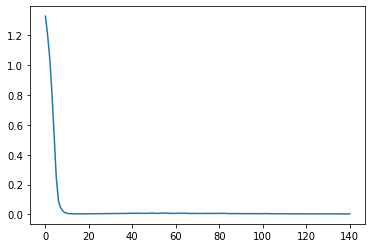

In [22]:
metrics = m.fit(df,
                freq="D",
                progress="plot")

WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


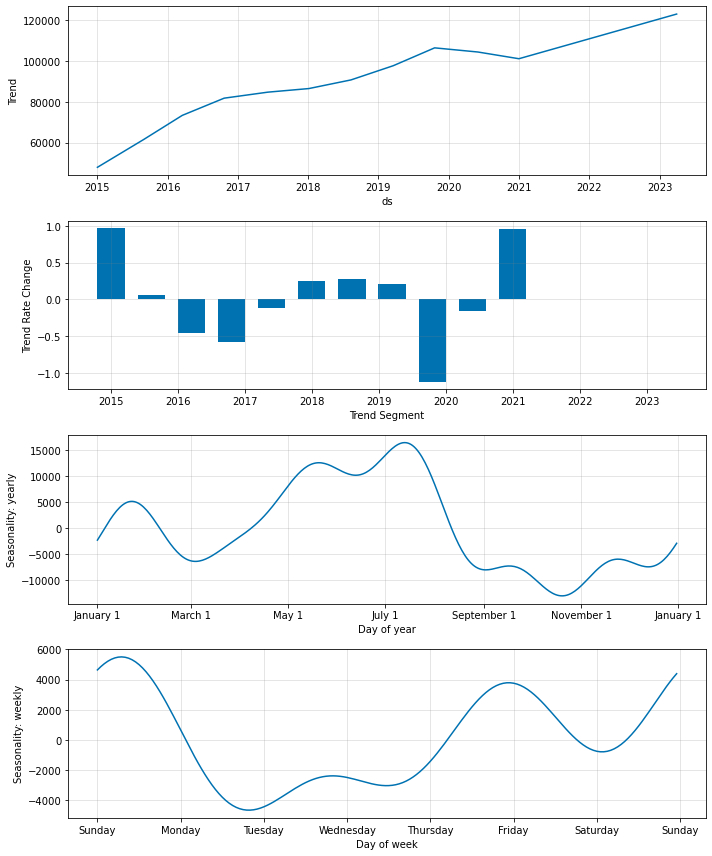

In [23]:
fig_param = m.plot_parameters()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.967% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D


Predicting: 95it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


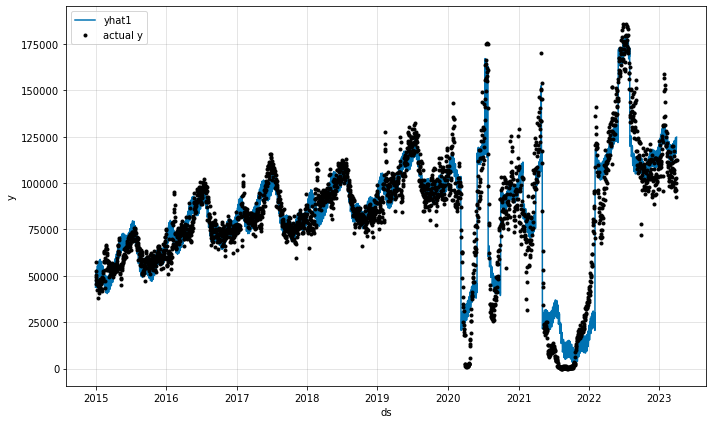

In [24]:
forecast = m.predict(df, decompose = True)
fig = m.plot(forecast)

In [25]:
forecast

,ds,y,yhat1,trend,season_yearly,season_weekly,events_additive,event_No_int,event_covid_1,event_covid_2,event_covid_3,event_covid_4
0,2015-01-01,"52,356","43,852","47,873","-2,615","-1,405",0,0,0,0,0,0
1,2015-01-02,"47,811","49,562","47,929","-2,126","3,758",0,0,0,0,0,0
2,2015-01-03,"49,555","45,610","47,985","-1,628",-748,0,0,0,0,0,0
3,2015-01-04,"57,680","51,553","48,042","-1,125","4,636",0,0,0,0,0,0
4,2015-01-05,"50,193","48,138","48,098",-621,661,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3007,2023-03-27,"102,822","120,748","122,867","-2,780",661,0,0,0,0,0,0
3008,2023-03-28,"92,698","115,906","122,894","-2,567","-4,422",0,0,0,0,0,0
3009,2023-03-29,"96,072","118,086","122,921","-2,354","-2,481",0,0,0,0,0,0
3010,2023-03-30,"100,110","119,402","122,947","-2,140","-1,405",0,0,0,0,0,0
